In [4]:
import pandas as pd
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import numpy as np

import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

#!pip install yfinance
#!pip install --upgrade yfinance
#!pip install yahoo_fin

In [2]:
#PAST DJIA
custom_tickers = [
    "^DJI",    # Dow Jones Industrial Average (DJI)
    "^GSPC",   # S&P 500
    "^IXIC",   # NASDAQ Composite
    "^FTSE",   # FTSE 100
    "^RUT",   # RUT
    "^N225",
    "^RMCC",
    "^MID"
]


# Fetch data for each ticker
stock_data = {}
for ticker in custom_tickers:
    try:
        data = get_data(ticker)
        stock_data[ticker] = data
    except AssertionError as e:
        print(f"No data found for {ticker}: {e}")
        
sandp_time = stock_data["^GSPC"]

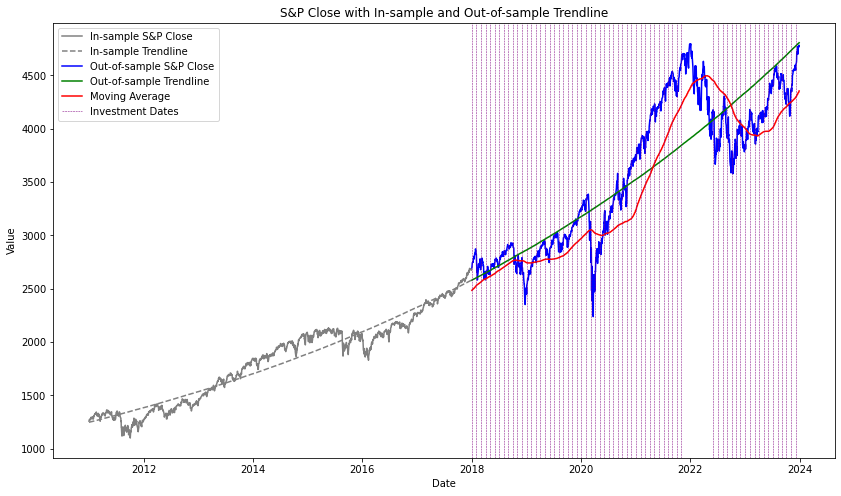

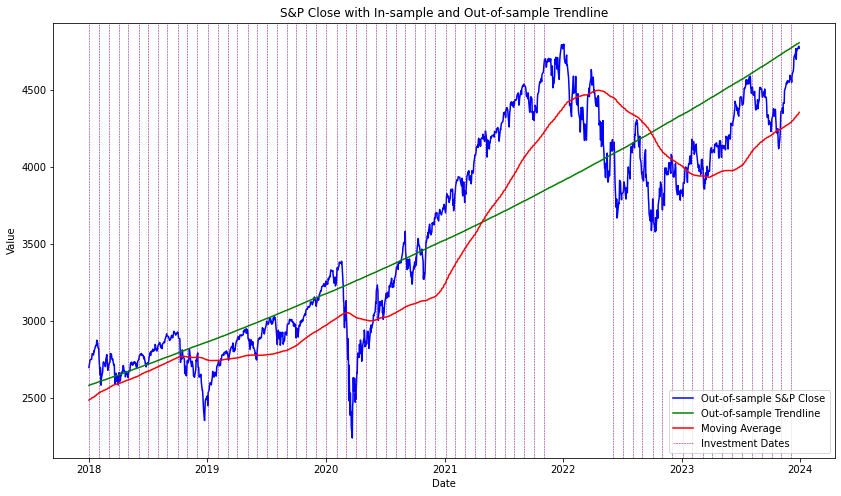

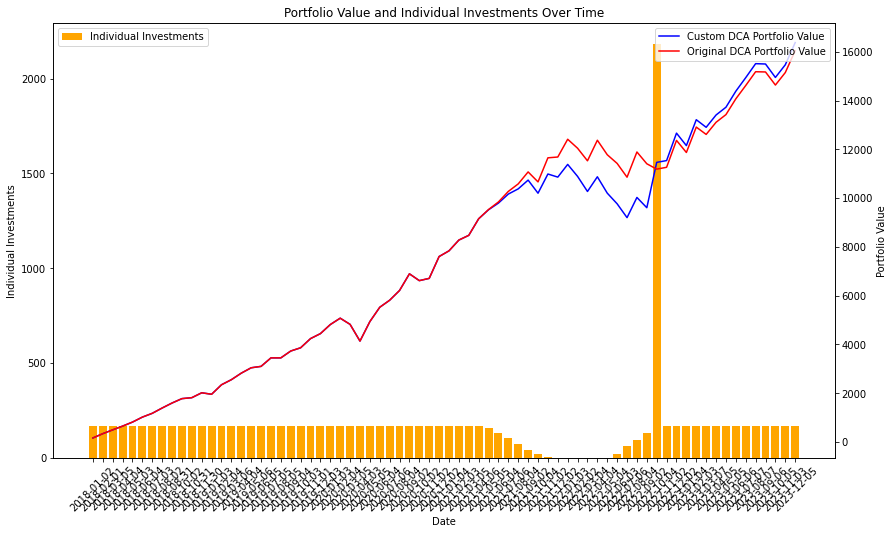

Custom DCA Value:  16374.693660196273
Original DCA Value:  16040.72120357599
Percent (Custom/Original):  102.08202893362319


In [14]:
def dca_analysis(sandp_time, trendline_multiplier, moving_average_window, time_interval, training_start_date, training_end_date, testing_start_date, testing_end_date,max_val,show_graph):
    sandp_time.index = pd.to_datetime(sandp_time.index)
    
#     def custom_dca_strategy(df, investment_amount, interval, moving_averages_df, trendline_multiplier):
#         shares_owned = 0
#         portfolio_value = []
#         dates = []
#         investment_history = []
#         aggregated_investment = 0

#         for i in range(0, len(df), interval):
#             current_price = df.iloc[i]['close']
#             ma_value = moving_averages_df['Moving Average'][i]
#             trendline_value = df['Trendline'][i]
    
#             invested_period = investment_amount + aggregated_investment
            
#             if ma_value * trendline_multiplier < trendline_value or i >= (len(df) - interval - 2):
#                 shares_bought = invested_period / current_price
#                 shares_owned += shares_bought
                
#                 current_value = shares_owned * current_price
#                 portfolio_value.append(current_value)
#                 dates.append(df.index[i])
                
#                 investment_history.append(invested_period)
#                 aggregated_investment = 0 
#             else:
#                 current_value = shares_owned * current_price
#                 portfolio_value.append(current_value)
#                 dates.append(df.index[i])
#                 investment_history.append(0)

#                 aggregated_investment += investment_amount

#         return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)
    
    def custom_dca_strategy(df, initial_investment, interval, moving_averages_df, trendline_multiplier):
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []
        remaining_investment = 0

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            ma_value = moving_averages_df['Moving Average'][i]
            trendline_value = df['Trendline'][i]

            if ma_value * trendline_multiplier < trendline_value or i >= (len(df) - interval - 2):
                # Calculate the total available investment including remaining amount
                total_investment = remaining_investment + initial_investment
                shares_bought = total_investment / current_price
                
                shares_owned += shares_bought
                current_value = shares_owned * current_price
                portfolio_value.append(current_value)
                dates.append(df.index[i])
                investment_history.append(total_investment)
                remaining_investment = 0
            else:
                # Calculate the amount to invest based on the difference between MA and trendline
                distance_percentage = (ma_value - trendline_value) / trendline_value
                adjustment_factor = 0
                if distance_percentage < max_val:
                    #adjustment_factor =  (1 - distance_percentage * 1/max_val) 
                    adjustment_factor = max(1 - distance_percentage * max_val,0)
            
        
                amount_to_invest = initial_investment * adjustment_factor 
                shares_bought = amount_to_invest / current_price
                shares_owned += shares_bought

                current_value = shares_owned * current_price
                portfolio_value.append(current_value)
                dates.append(df.index[i])
                investment_history.append(amount_to_invest)
                # Update remaining investment
                remaining_investment += initial_investment - amount_to_invest

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)
    
    def original_dca_strategy(df, investment_amount, interval):
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            shares_bought = investment_amount / current_price
            shares_owned += shares_bought

            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(investment_amount)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)
    
    # Split the dataset into in-sample (training) and out-of-sample (testing)
    training_df = sandp_time[training_start_date:training_end_date]
    testing_df = sandp_time[testing_start_date:testing_end_date]

    # Fit the curve on the training dataset
    def exponential_func(x, a, b):
        return a * np.exp(b * x)
    
    x_values_train = np.arange(len(training_df))
    y_values_train = training_df['close']
    initial_guess = (1.0, 0.001)
    popt, pcov = curve_fit(exponential_func, x_values_train, y_values_train, p0=initial_guess)
    trendline_train = exponential_func(x_values_train, *popt)

    # Apply the trendline to the testing dataset
    x_values_test = np.arange(len(testing_df)) + len(training_df)
    trendline_test = exponential_func(x_values_test, *popt)
    testing_df['Trendline'] = trendline_test

    # Calculate moving averages for the testing dataset
    moving_averages_test = pd.DataFrame()
    full_set = sandp_time[training_start_date:testing_end_date]
    moving_averages_test['Moving Average'] = full_set['close'].rolling(window=moving_average_window).mean()[len(full_set)-len(testing_df):]

    # Calculate the investment strategy results on the testing dataset
    custom_result = custom_dca_strategy(testing_df, 8 * time_interval, time_interval, moving_averages_test, trendline_multiplier)
    original_result = original_dca_strategy(testing_df, 8 * time_interval, time_interval)

    
    
    
    # Plotting
    if show_graph:
        plt.figure(figsize=(14, 8))
        # Plot in-sample data
        plt.plot(training_df.index, training_df['close'], label='In-sample S&P Close', color='gray')
        plt.plot(training_df.index, trendline_train, label='In-sample Trendline', color='gray', linestyle='--')
        # Plot out-of-sample data
        plt.plot(testing_df.index, testing_df['close'], label='Out-of-sample S&P Close', color='blue')
        plt.plot(testing_df.index, testing_df['Trendline'], label='Out-of-sample Trendline', color='green')
        plt.plot(testing_df.index, moving_averages_test['Moving Average'], label='Moving Average', color='red')

        for date in custom_result.index[custom_result['investment_history'] > 0]:
            plt.axvline(x=date, color='purple', linestyle='--', linewidth=0.5, label='Investment Dates' if 'Investment Dates' not in plt.gca().get_legend_handles_labels()[1] else "")

        plt.title('S&P Close with In-sample and Out-of-sample Trendline')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()


        plt.figure(figsize=(14, 8))
        plt.plot(testing_df.index, testing_df['close'], label='Out-of-sample S&P Close', color='blue')
        plt.plot(testing_df.index, testing_df['Trendline'], label='Out-of-sample Trendline', color='green')
        plt.plot(testing_df.index, moving_averages_test['Moving Average'], label='Moving Average', color='red')

        for date in custom_result.index[custom_result['investment_history'] > 0]:
            plt.axvline(x=date, color='purple', linestyle='--', linewidth=0.5, label='Investment Dates' if 'Investment Dates' not in plt.gca().get_legend_handles_labels()[1] else "")

        plt.title('S&P Close with In-sample and Out-of-sample Trendline')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        # Plot DCA Strategy Performance
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # Plotting the bar plot

    #     ax1.bar(custom_result.index.strftime('%Y-%m-%d'), custom_result['investment_history'], color='orange', label='Individual Investments')
    #     tick_frequency = 3  # Adjust this value according to your preference
    #     ax1.xticks(custom_result.index.strftime('%Y-%m-%d')[::tick_frequency], rotation=45)  

        ax1.bar(custom_result.index.strftime('%Y-%m-%d'), custom_result['investment_history'], color='orange', label='Individual Investments')

        # Creating a second y-axis
        ax2 = ax1.twinx()

        # Plotting the line plots on the second y-axis
        ax2.plot(custom_result.index.strftime('%Y-%m-%d'), custom_result['portfolio_value'], label='Custom DCA Portfolio Value', color='blue')
        ax2.plot(original_result.index.strftime('%Y-%m-%d'), original_result['portfolio_value'], label='Original DCA Portfolio Value', color='red')

        # Adding labels and legend
        ax1.set_title('Portfolio Value and Individual Investments Over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Individual Investments')
        ax2.set_ylabel('Portfolio Value')
        ax1.xaxis.set_tick_params(rotation=45)
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.show()

        print("Custom DCA Value: ", custom_result["portfolio_value"][-1])
        print("Original DCA Value: ", original_result["portfolio_value"][-1])
        print("Percent (Custom/Original): ", custom_result["portfolio_value"][-1]/original_result["portfolio_value"][-1]*100)

    return custom_result, original_result

# Define parameters
moving_average = 200
time_interv = 21
training_start_date = '2010-12-31'
training_end_date = '2017-12-31'
testing_start_date = '2018-01-01'
testing_end_date = '2024-01-01'
max_val = 10

final = dca_analysis(sandp_time, trendline_multiplier=1.0, moving_average_window=moving_average, time_interval=time_interv, training_start_date=training_start_date, training_end_date=training_end_date, testing_start_date=testing_start_date, testing_end_date=testing_end_date, max_val = max_val, show_graph = True)

In [456]:
def make_plots(moving_average=50, increment_years=5, trendline_multiplier=0.8,max_val=1.0):
#def make_plots(max_val):
    time_interv = 21
    date_start = '1980-06-01'
    date_end = '2024-06-01'
    test_period_years = 10  # Length of testing period
    final_results = []

    current_year = int(date_start[:4])

    while True:
        training_start_date = f"{current_year:04d}-01-01"
        training_end_date = f"{current_year + increment_years - 1:04d}-12-31"
        testing_start_date = f"{current_year + increment_years:04d}-01-01"
        testing_end_date = f"{current_year + increment_years + test_period_years - 1:04d}-12-31"
        #training_start_date = f"{current_year}-06-01"
        #training_end_date = f"{current_year + increment_years - 1}-06-30"
        #testing_start_date = f"{current_year + increment_years}-07-01"
        #testing_end_date = f"{current_year + increment_years + test_period_years - 1}-06-30"

        if testing_end_date > date_end:
            break

        result = dca_analysis(
            sandp_time,
            trendline_multiplier=trendline_multiplier,
            moving_average_window=moving_average,
            time_interval=time_interv,
            training_start_date = training_start_date,
            training_end_date=training_end_date,
            testing_start_date=testing_start_date,
            testing_end_date=testing_end_date,
            max_val = max_val,
            show_graph = False
        )
        final_results.append((training_start_date, training_end_date, testing_start_date, testing_end_date, result))
        current_year += 5

    current = []
    old = []

    for i in range(len(final_results)):
        current.append(final_results[i][4][0]["portfolio_value"][-1])
        old.append(final_results[i][4][1]["portfolio_value"][-1])
        #print(current[i]/old[i])

    percents = np.array(current)/np.array(old)
    return np.mean(percents)

In [457]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'moving_average': [50, 100, 200, 300, 500],
    'increment_years': np.arange(1,12,4),
    'trendline_multiplier': [0.7, 0.8, 0.9, 1.0],
    'max_val': [0.01,0.1,1,2,10]
}

# Generate combinations
param_combinations = ParameterGrid(param_grid)

best_performance = float('-inf')
best_parameters = None

# Iterate over parameter combinations
for params in param_combinations:
    # Run make_plots with current parameters and evaluate performance
    performance = make_plots(**params)
    
    # Update best parameters if current performance is better
    if performance > best_performance:
        best_performance = performance
        best_parameters = params
        print(params)
        print(performance)

print("Best parameters:", best_parameters)
print("Best performance:", best_performance)

{'increment_years': 1, 'max_val': 0.01, 'moving_average': 50, 'trendline_multiplier': 0.7}
0.948343469109555
{'increment_years': 1, 'max_val': 0.01, 'moving_average': 200, 'trendline_multiplier': 0.7}
0.950698756658765
{'increment_years': 1, 'max_val': 0.01, 'moving_average': 300, 'trendline_multiplier': 0.7}
0.9507835941874527
{'increment_years': 1, 'max_val': 0.01, 'moving_average': 500, 'trendline_multiplier': 0.8}
0.9515443600546571
{'increment_years': 1, 'max_val': 1, 'moving_average': 50, 'trendline_multiplier': 0.7}
0.9623232375094349
{'increment_years': 1, 'max_val': 1, 'moving_average': 100, 'trendline_multiplier': 0.7}
0.9626626025743258
{'increment_years': 1, 'max_val': 1, 'moving_average': 200, 'trendline_multiplier': 0.7}
0.9637632887752398
{'increment_years': 1, 'max_val': 1, 'moving_average': 300, 'trendline_multiplier': 0.7}
0.9637654171766281


KeyboardInterrupt: 

In [ ]:
#Best parameters: {'increment_years': 5, 'moving_average': 44, 'trendline_multiplier': 0.8}
#Best performance: 1.002180742554028

In [ ]:
# Define parameters
moving_average = 200
time_interv = 21
training_start_date = '2010-12-31'
training_end_date = '2017-12-31'
testing_start_date = '2018-01-01'
testing_end_date = '2024-01-01'
max_val = 10

final = dca_analys

In [ ]:
final = dca_analysis(sandp_time, 
                     trendline_multiplier=1.0, 
                     moving_average_window=moving_average, 
                     time_interval=time_interv, 
                     training_start_date=training_start_date, 
                     training_end_date=training_end_date, 
                     testing_start_date=testing_start_date, 
                     testing_end_date=testing_end_date, 
                     max_val = max_val, 
                     show_graph = True)

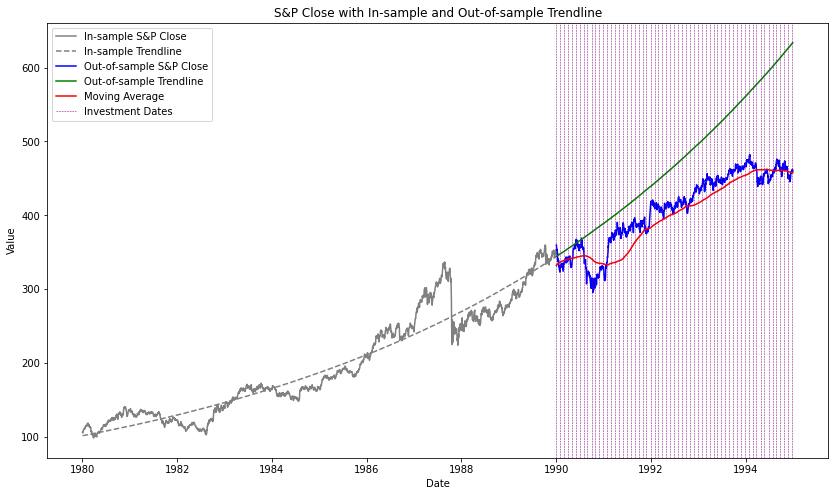

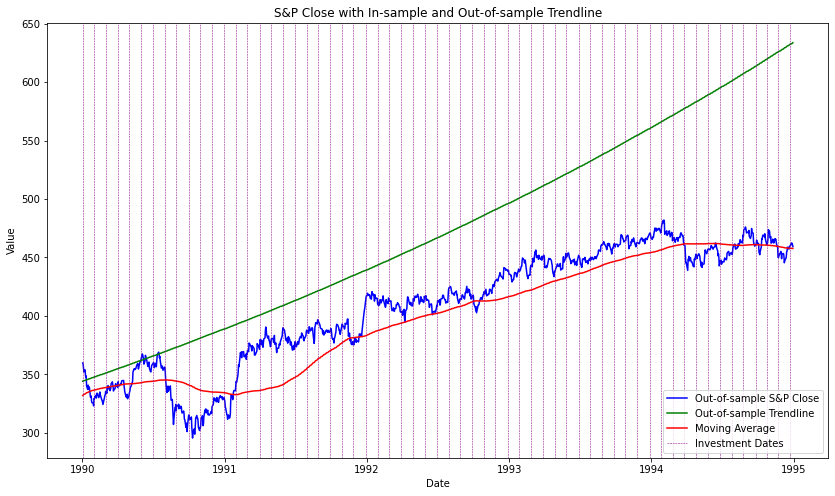

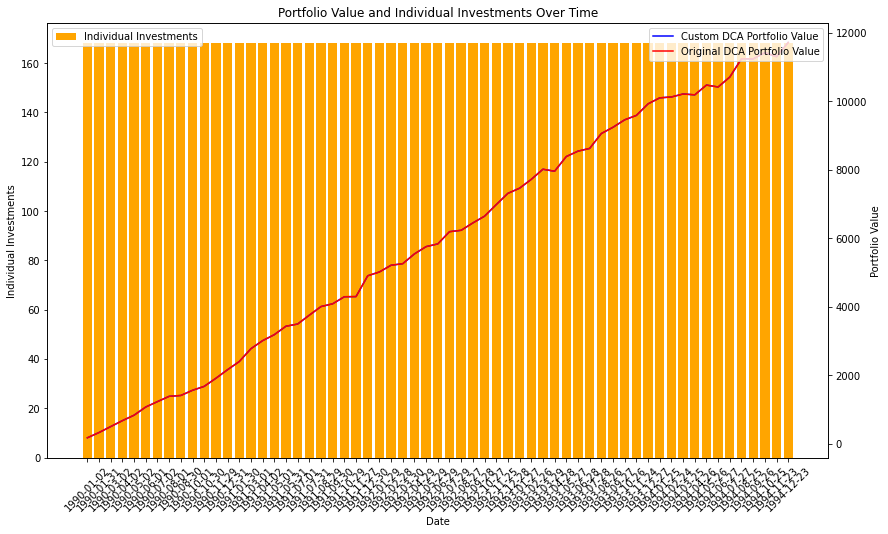

Custom DCA Value:  11721.470748188378
Original DCA Value:  11721.470748188378
Percent (Custom/Original):  100.0


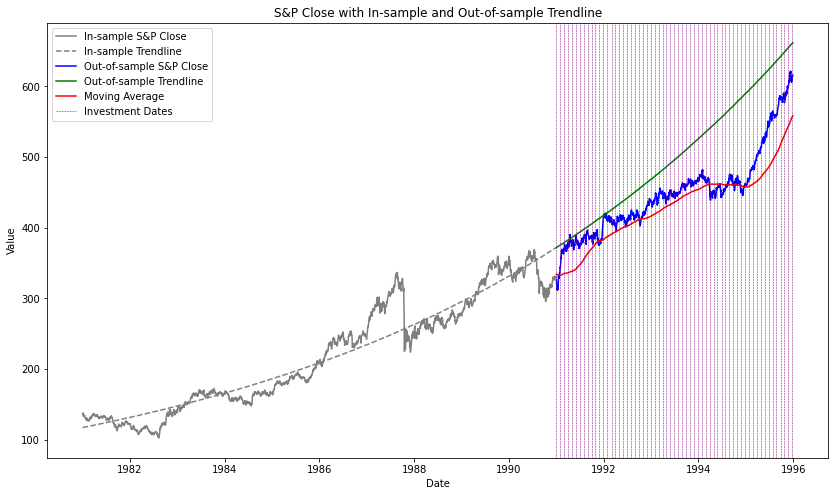

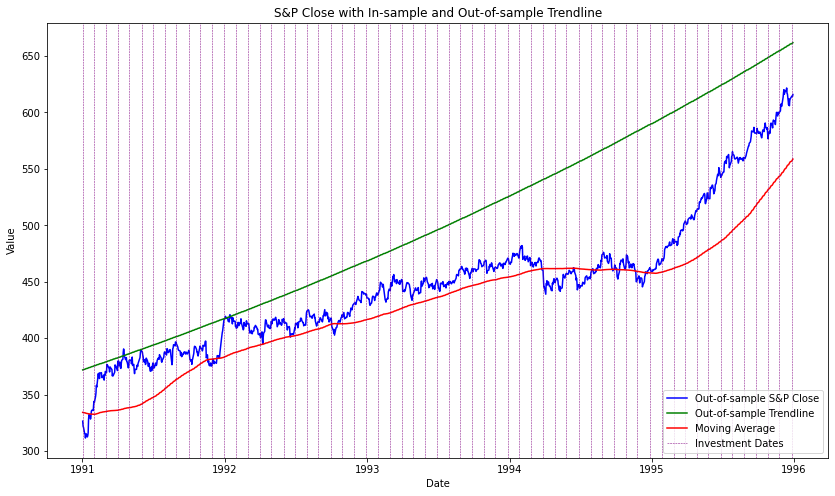

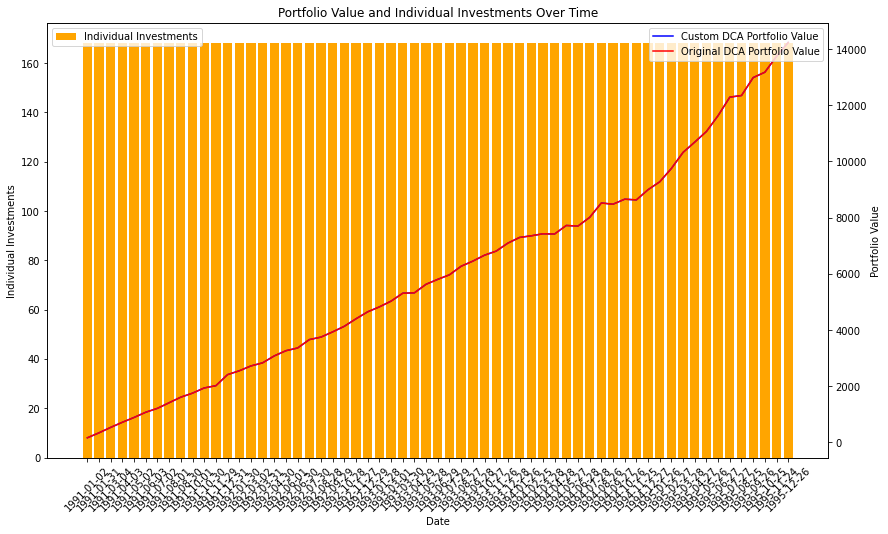

Custom DCA Value:  14236.223332898566
Original DCA Value:  14236.223332898566
Percent (Custom/Original):  100.0


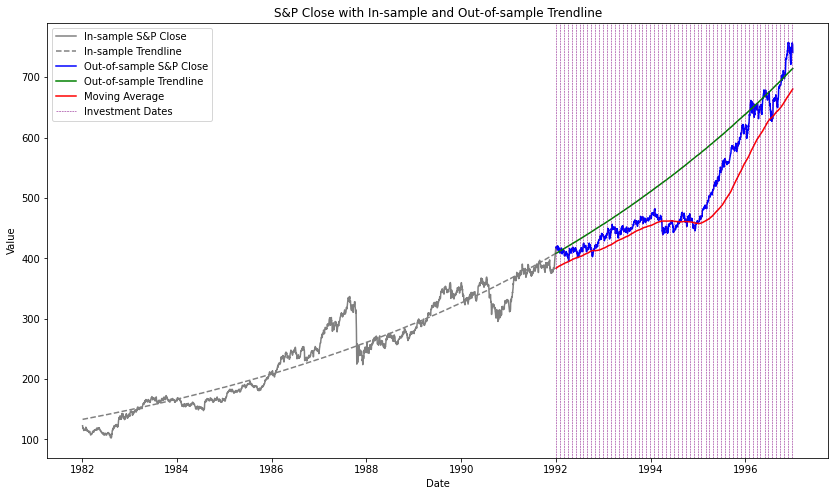

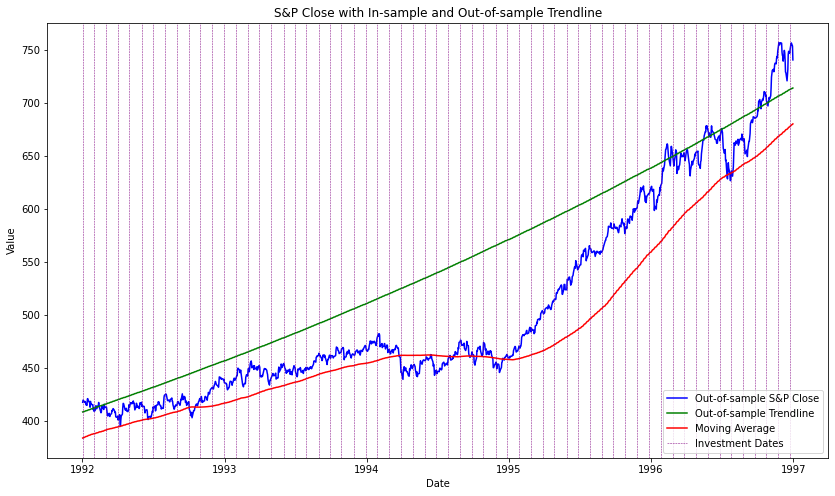

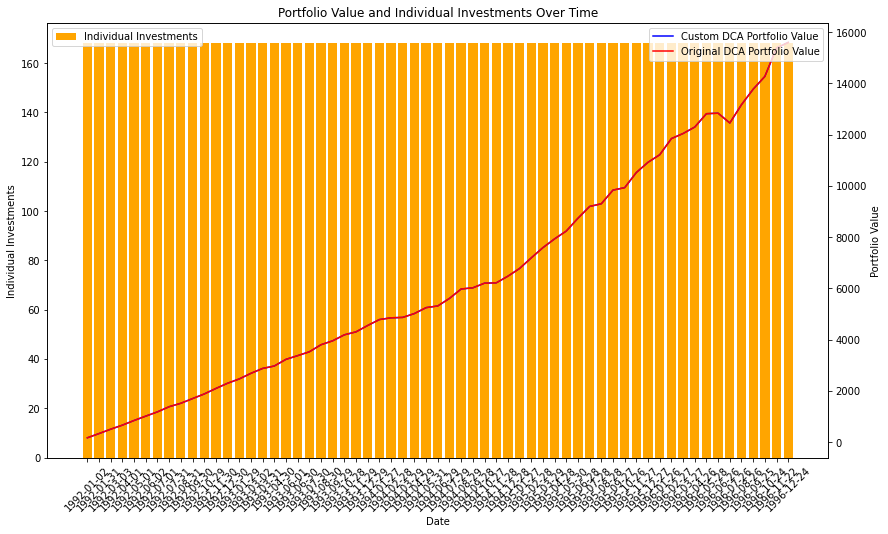

Custom DCA Value:  15597.407692312745
Original DCA Value:  15597.407692312745
Percent (Custom/Original):  100.0


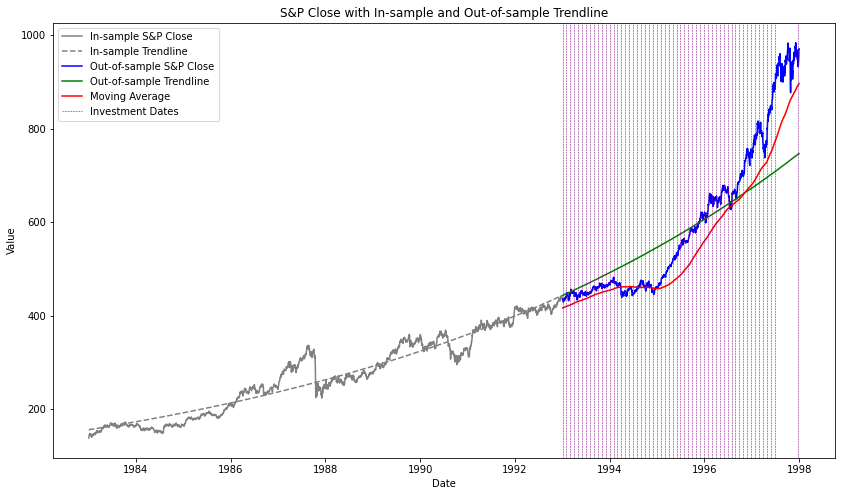

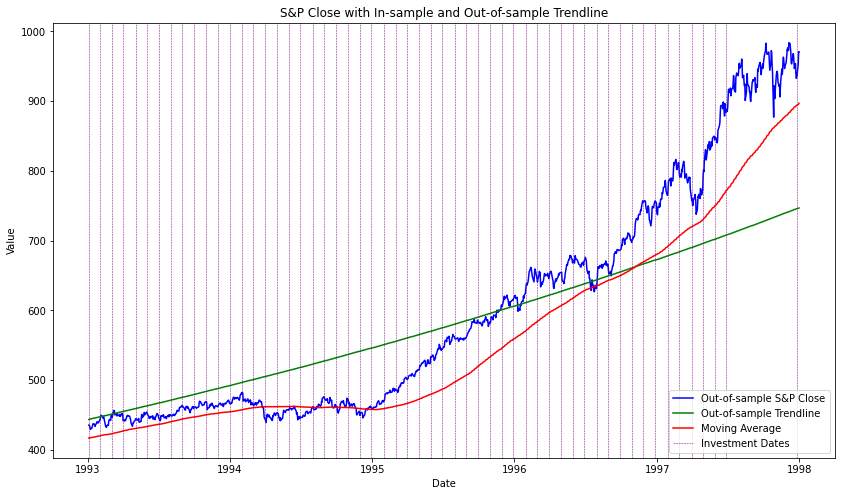

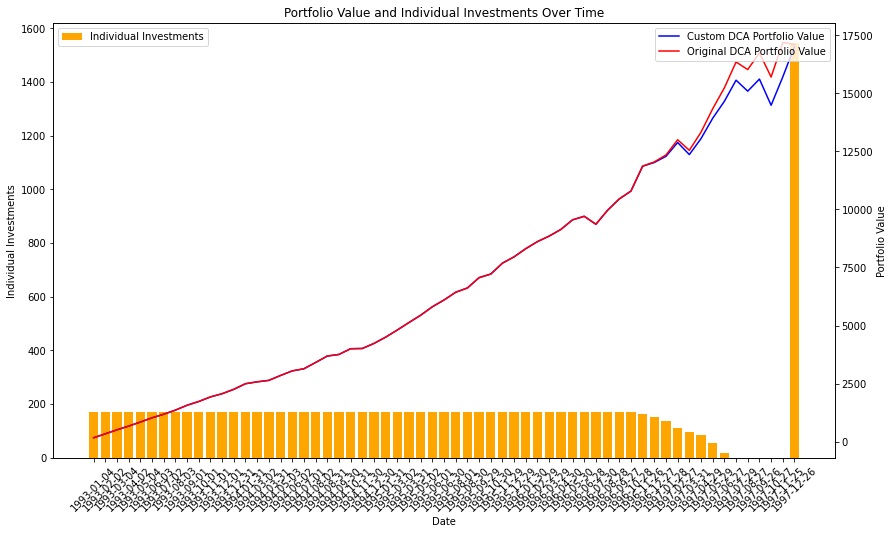

Custom DCA Value:  17006.003926228288
Original DCA Value:  17092.823224984106
Percent (Custom/Original):  99.49207162788113


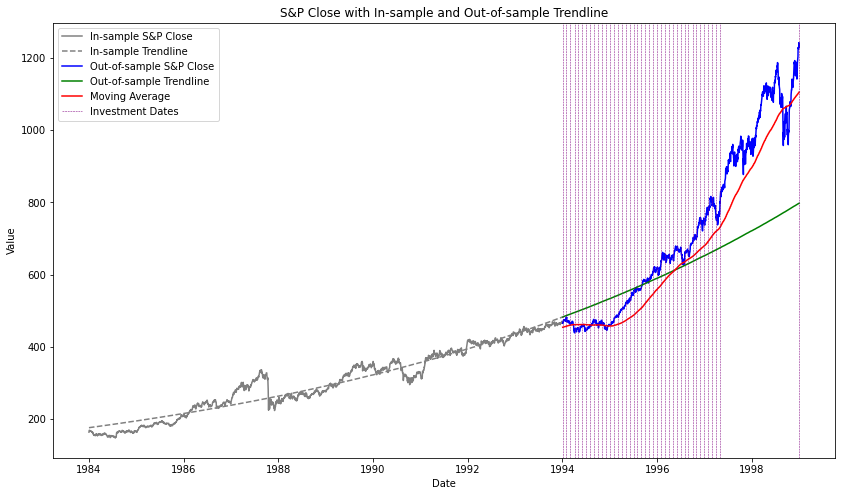

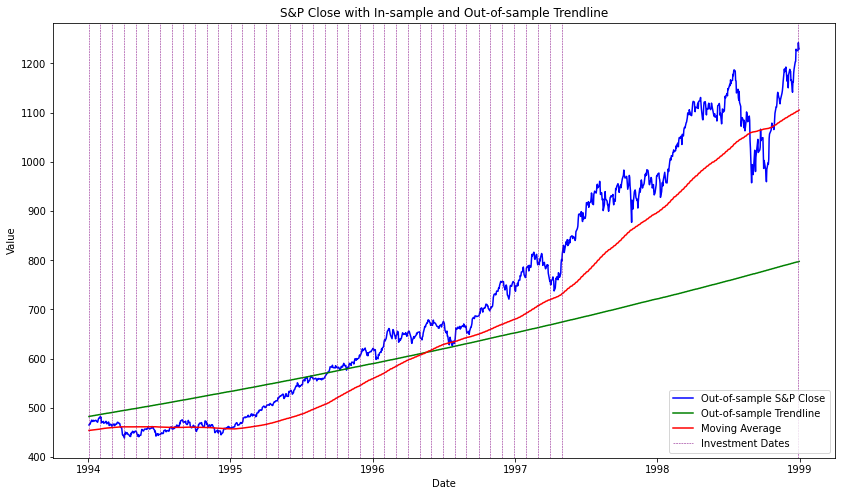

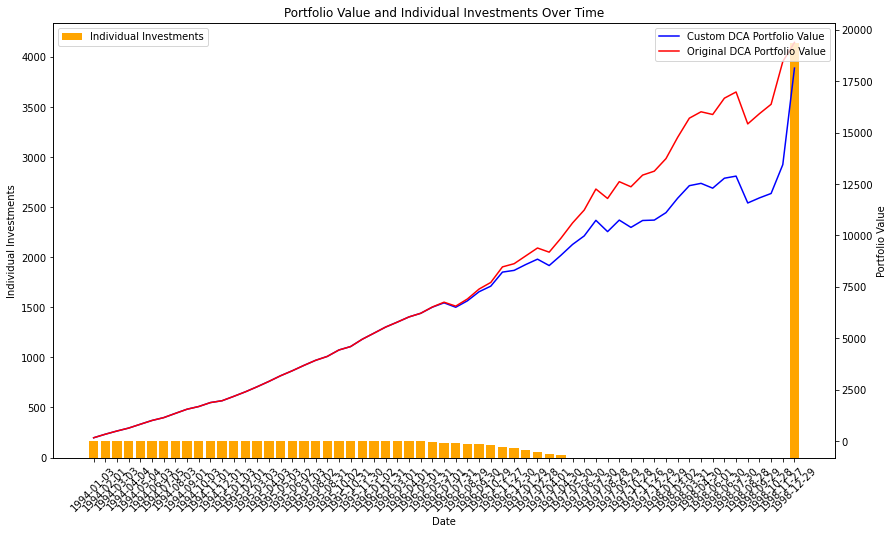

Custom DCA Value:  18135.787023647976
Original DCA Value:  19383.68825789111
Percent (Custom/Original):  93.56210635643548


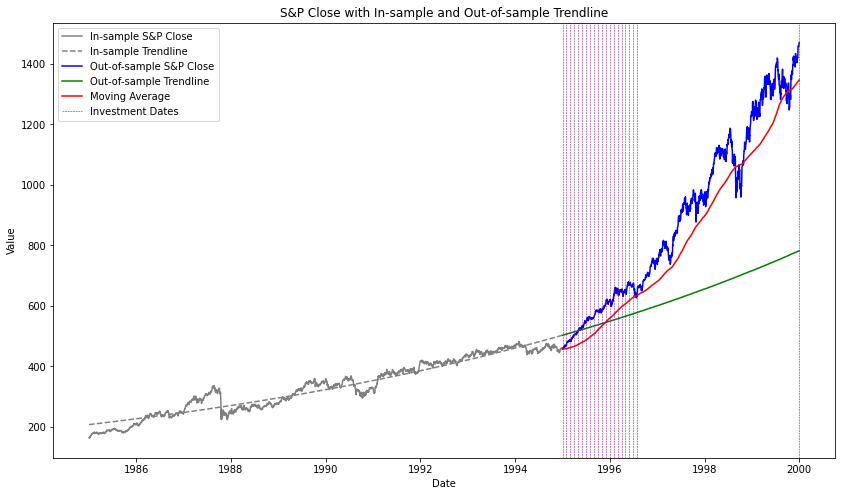

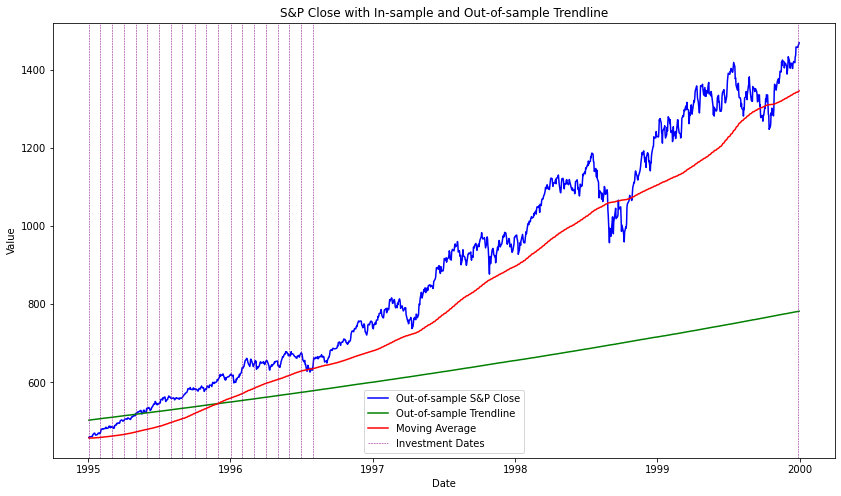

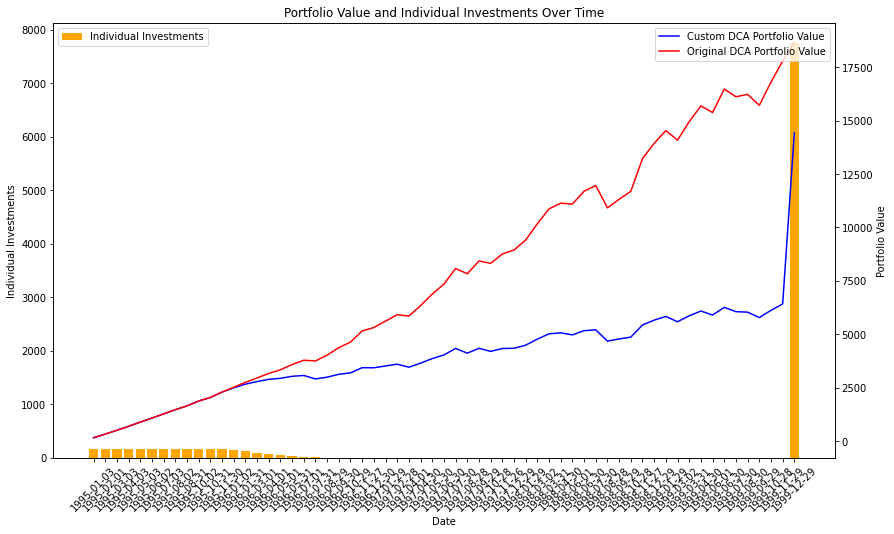

Custom DCA Value:  14424.955252672102
Original DCA Value:  18652.079632454603
Percent (Custom/Original):  77.33698084567841


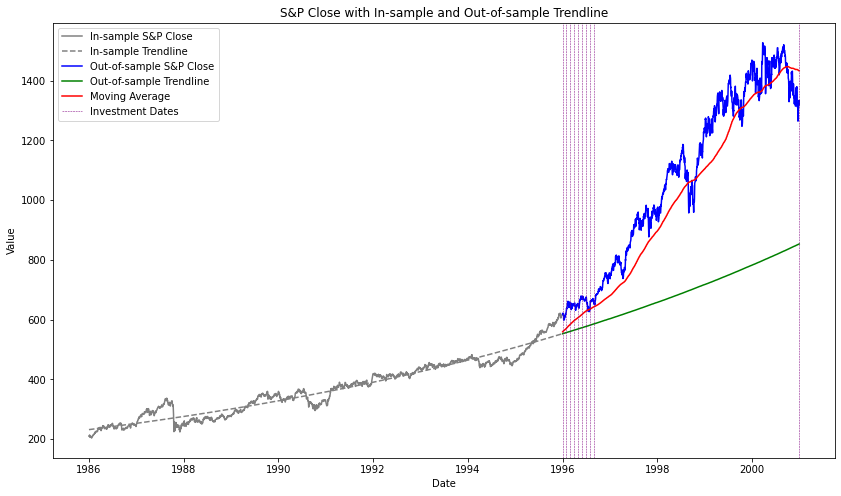

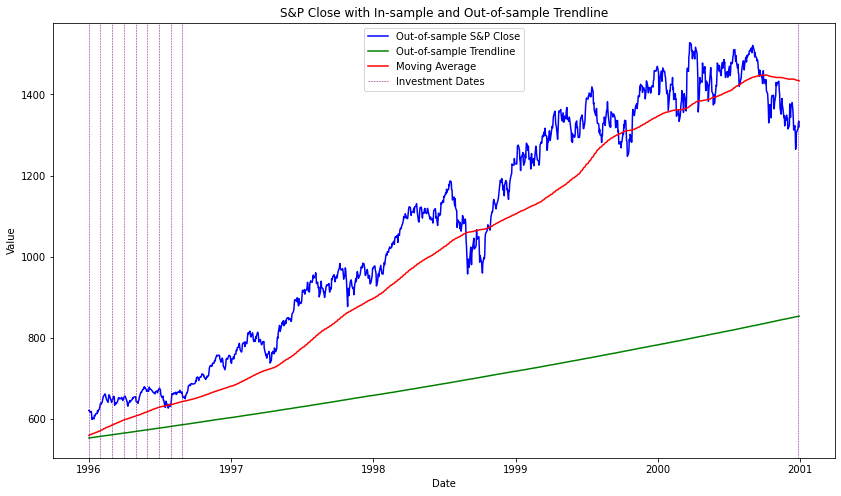

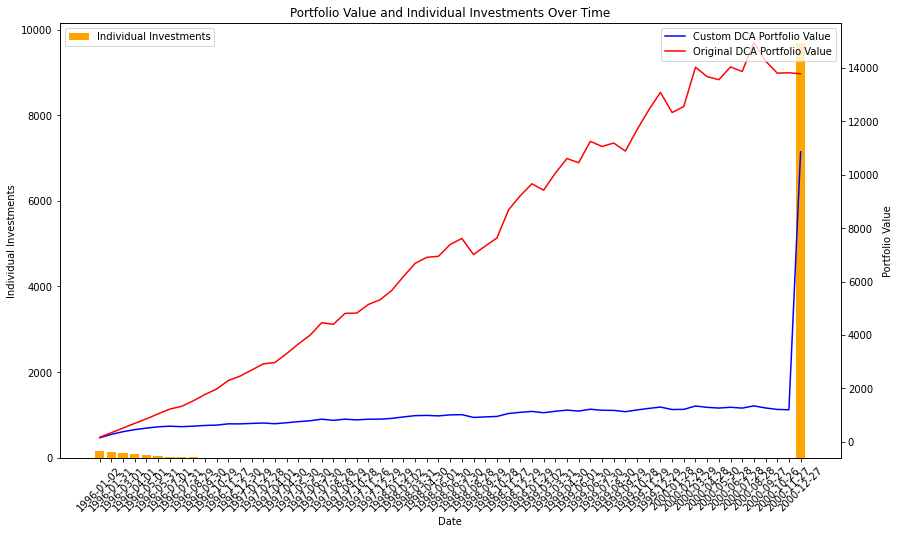

Custom DCA Value:  10858.179773323563
Original DCA Value:  13779.93546649483
Percent (Custom/Original):  78.79702920035179


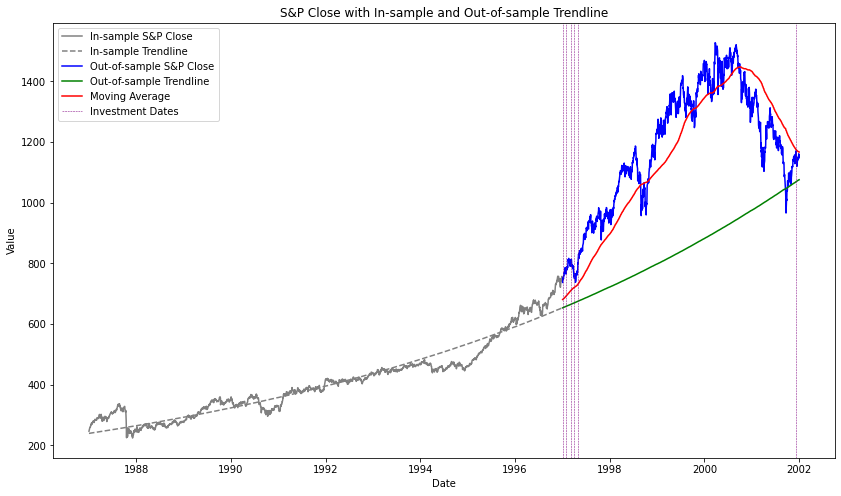

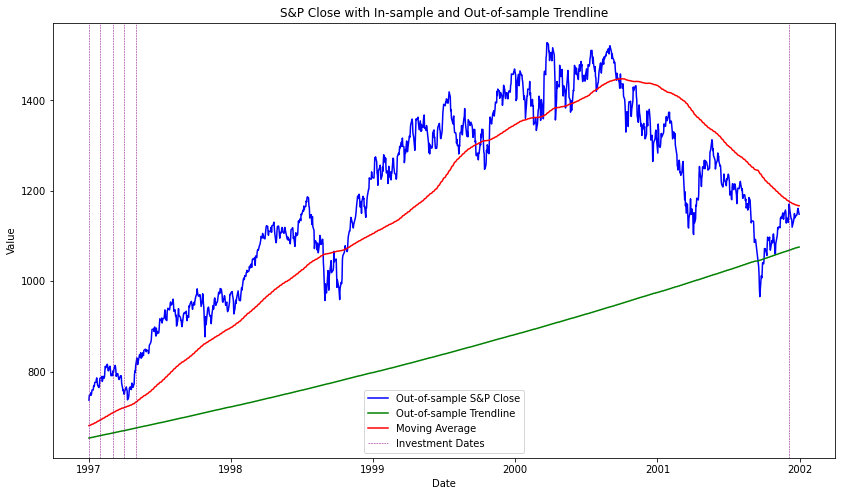

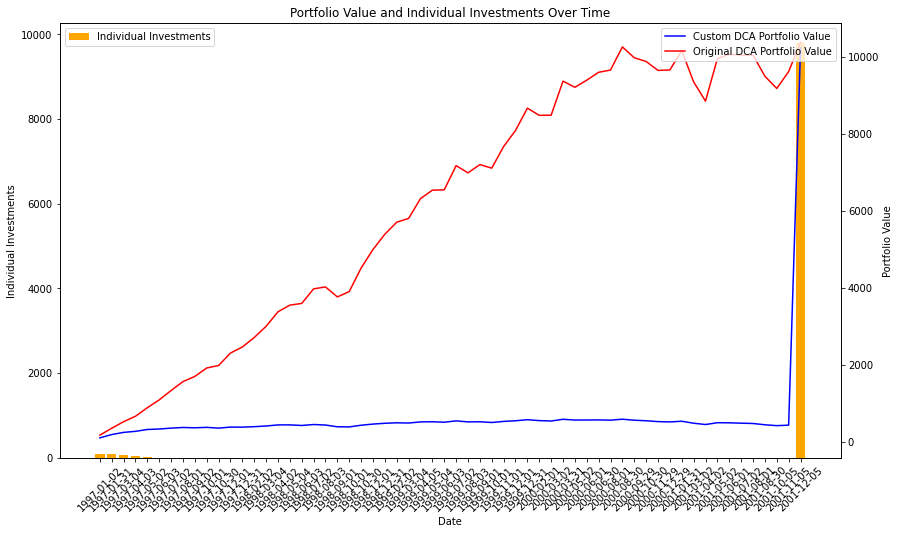

Custom DCA Value:  10236.054645494674
Original DCA Value:  10377.53800551009
Percent (Custom/Original):  98.63663847879629


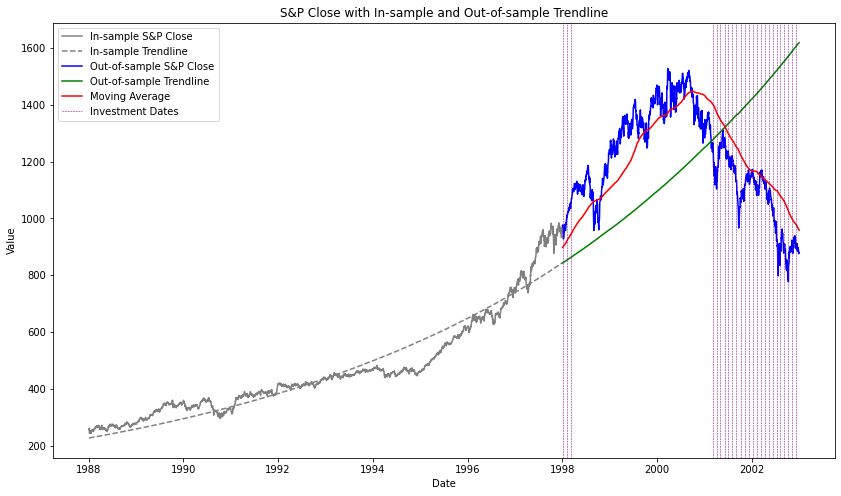

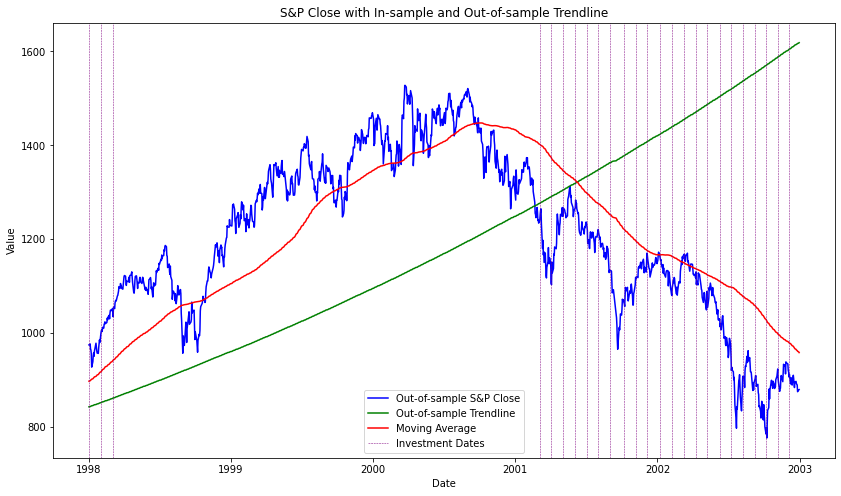

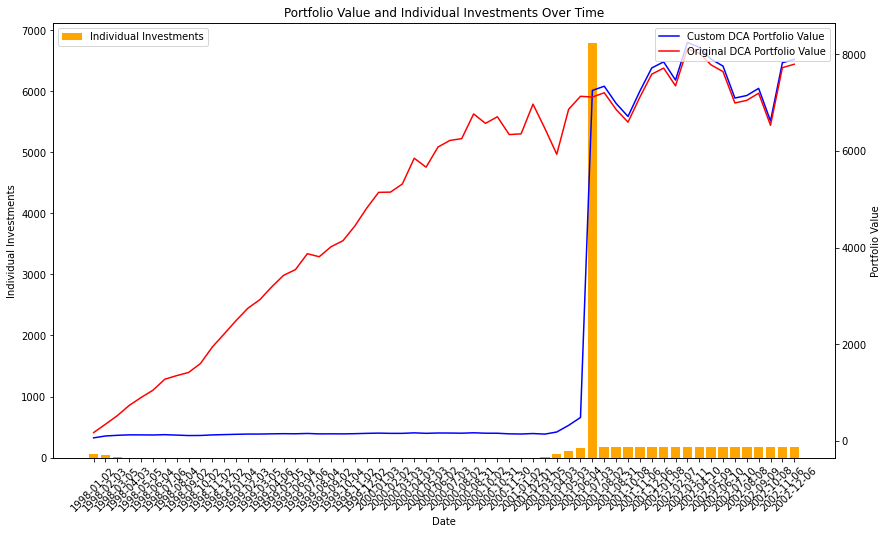

Custom DCA Value:  7895.59083193802
Original DCA Value:  7794.391804602699
Percent (Custom/Original):  101.2983569452534


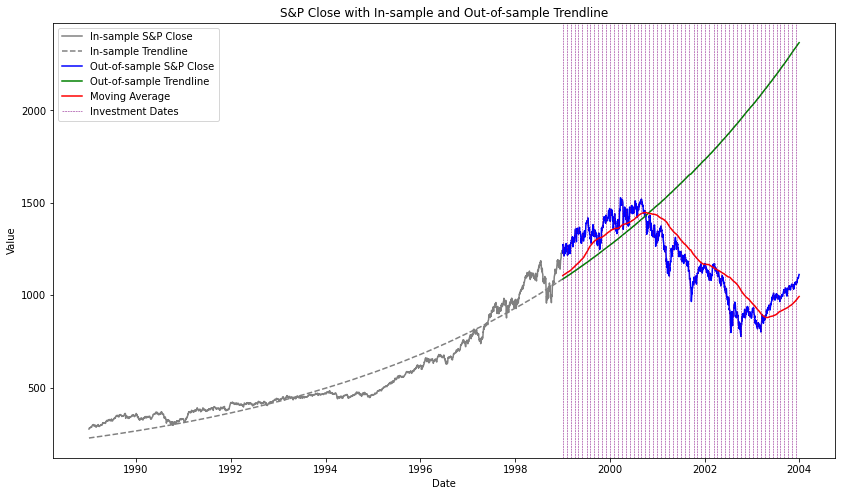

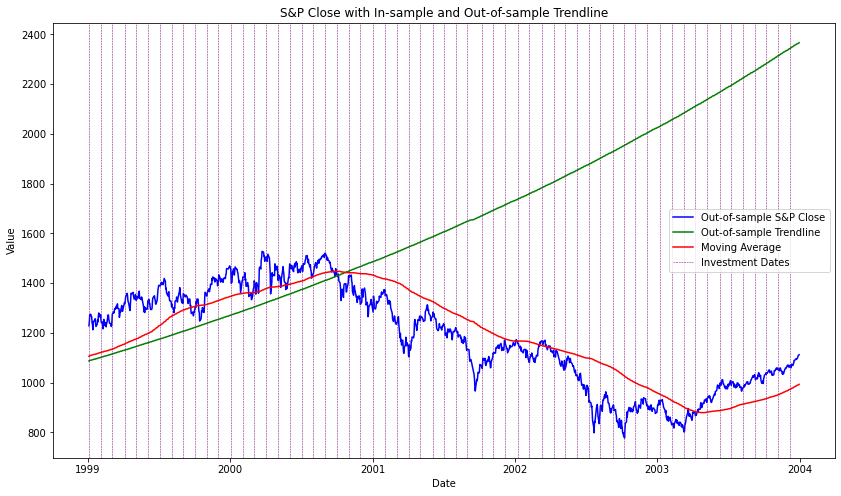

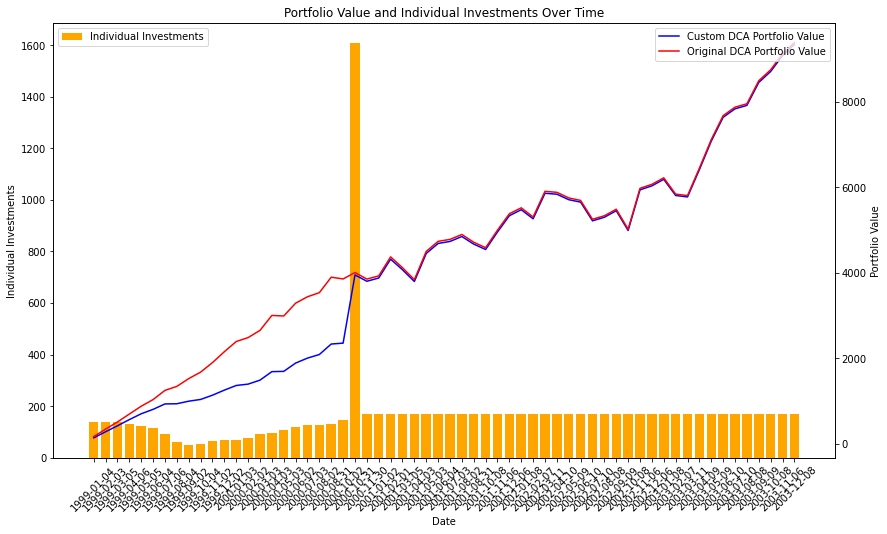

Custom DCA Value:  9348.214974041059
Original DCA Value:  9389.822934754817
Percent (Custom/Original):  99.55688237144756


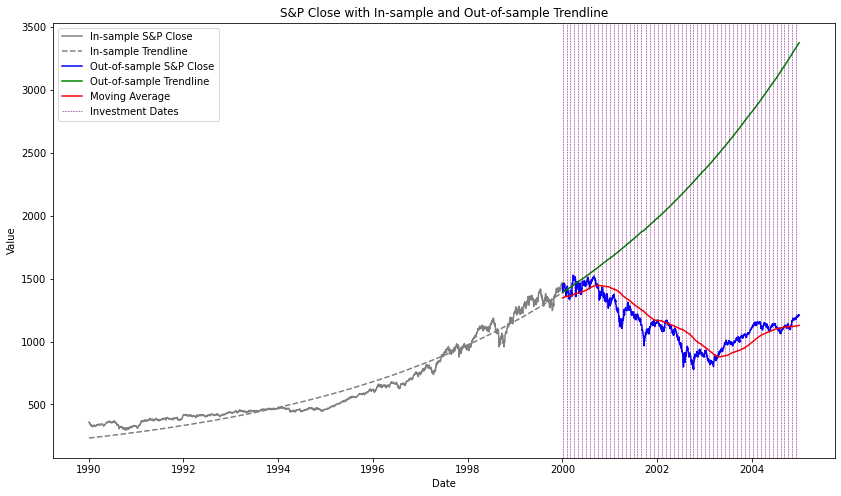

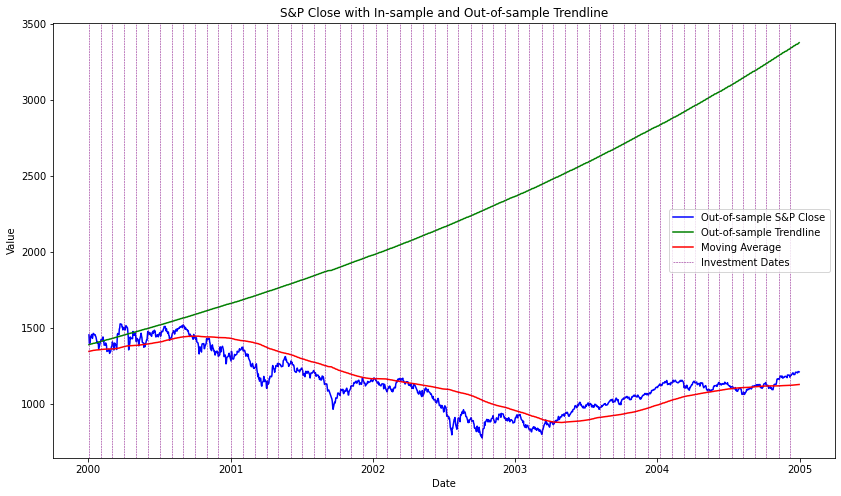

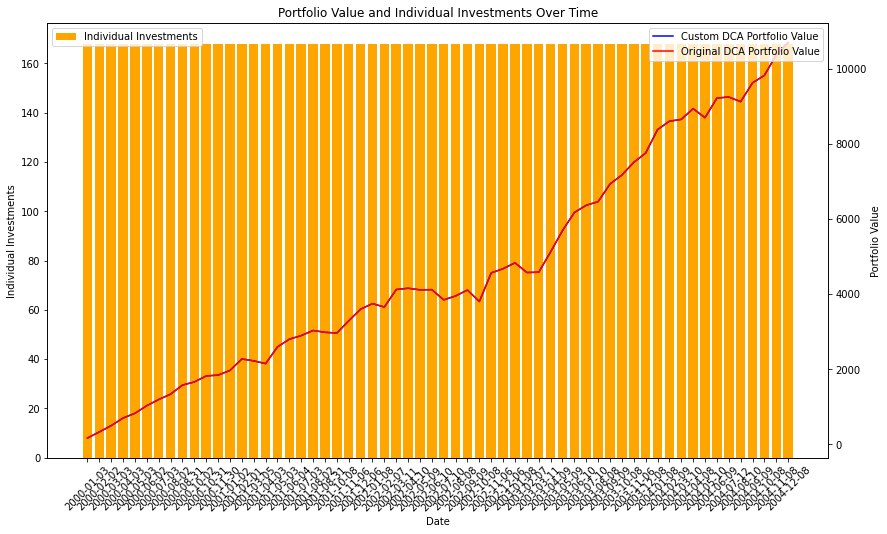

Custom DCA Value:  10693.404363755408
Original DCA Value:  10693.404363755408
Percent (Custom/Original):  100.0


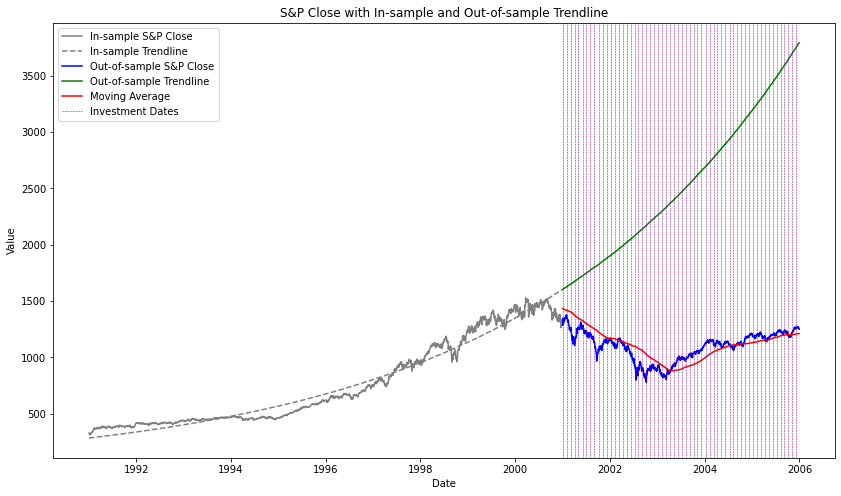

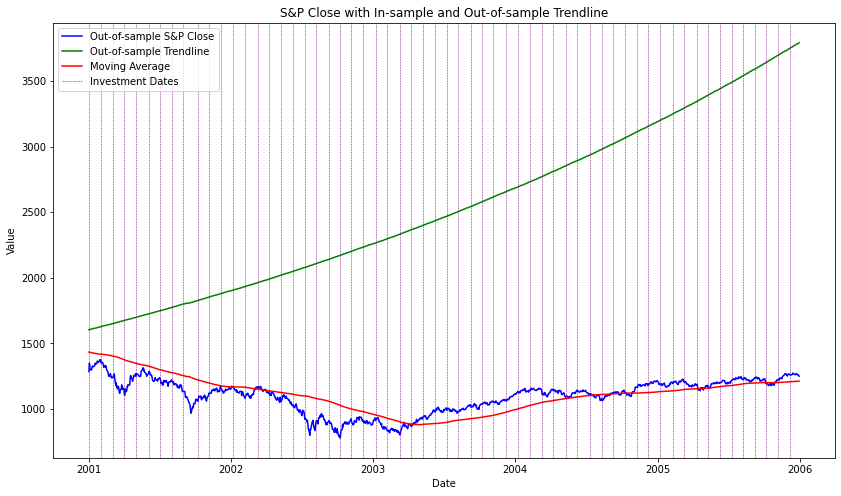

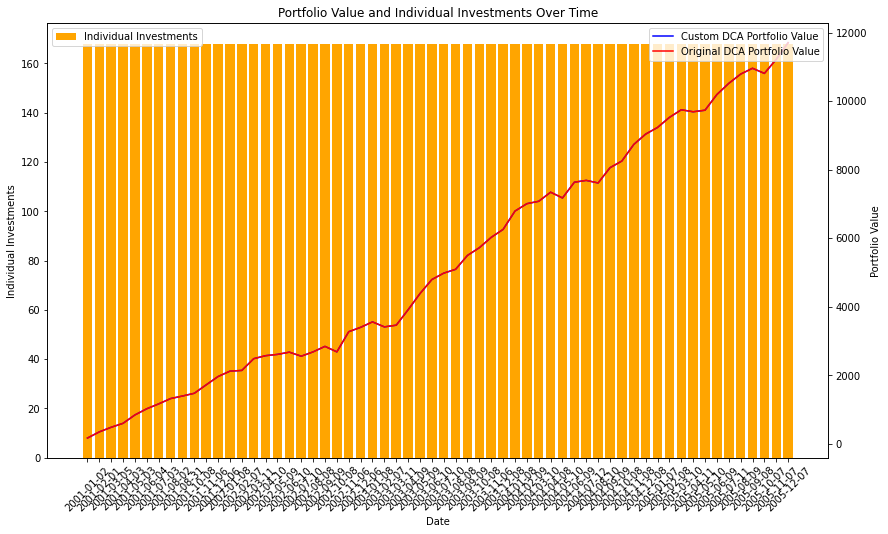

Custom DCA Value:  11702.694875123228
Original DCA Value:  11702.694875123228
Percent (Custom/Original):  100.0


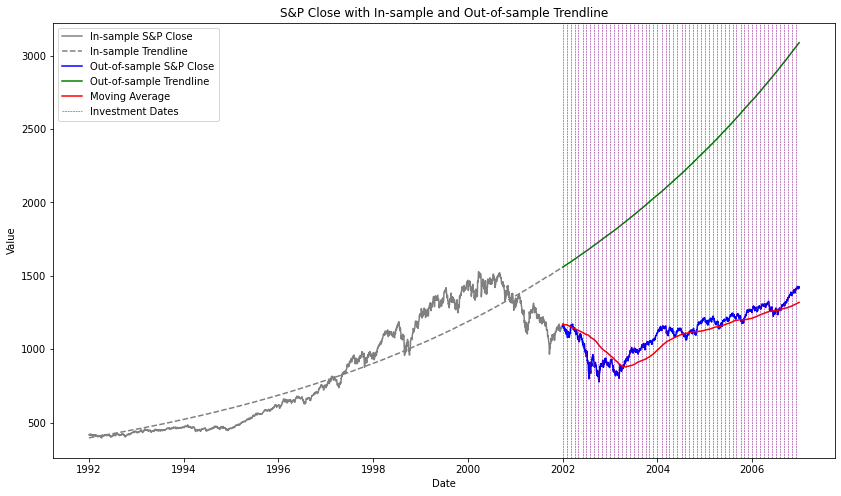

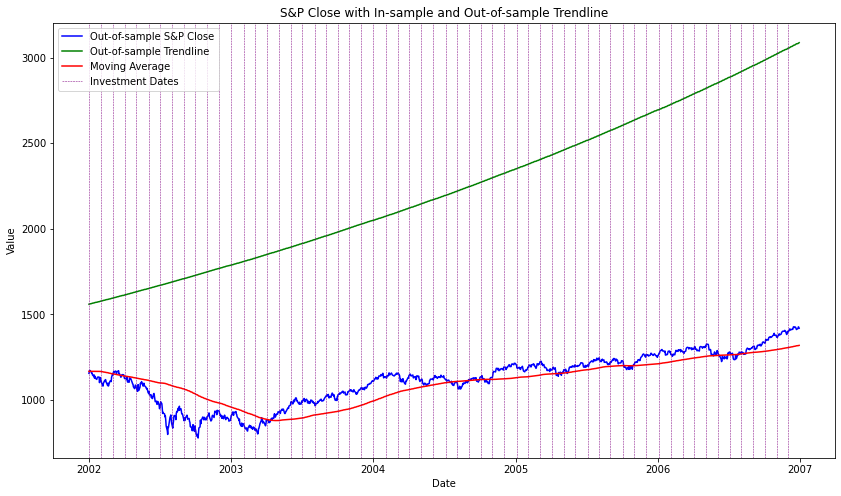

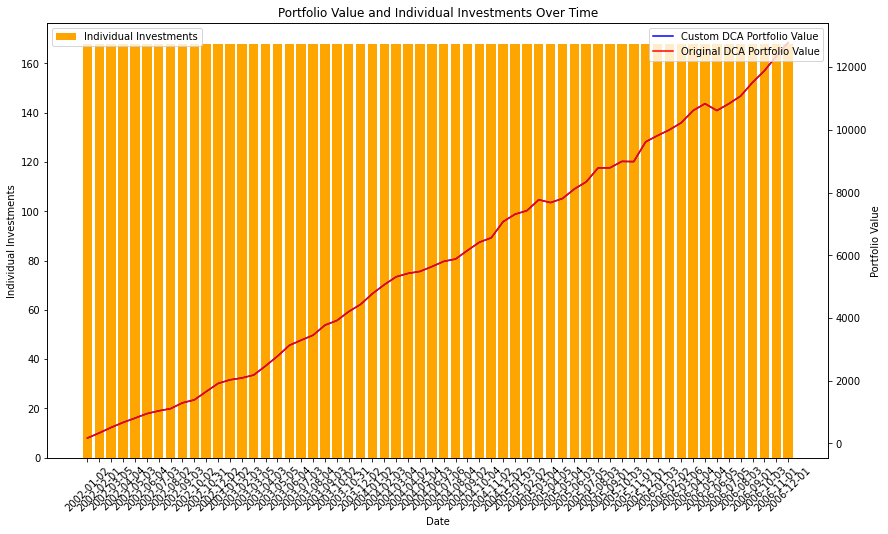

Custom DCA Value:  12781.354867560418
Original DCA Value:  12781.354867560418
Percent (Custom/Original):  100.0


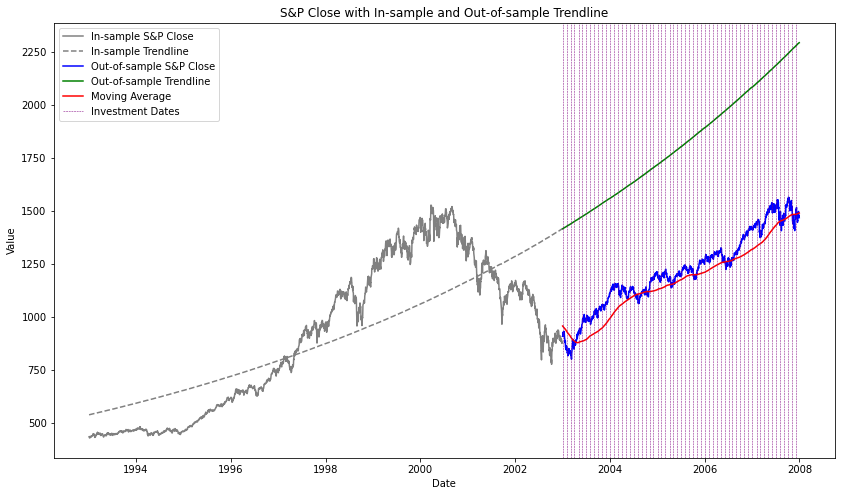

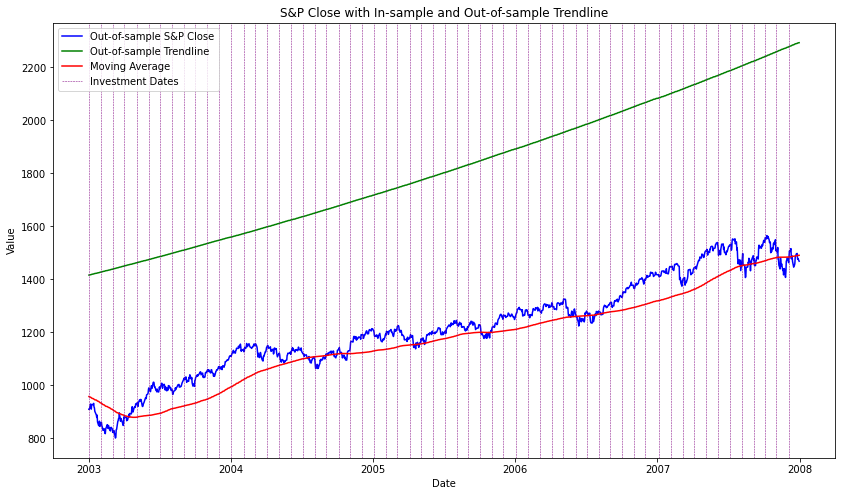

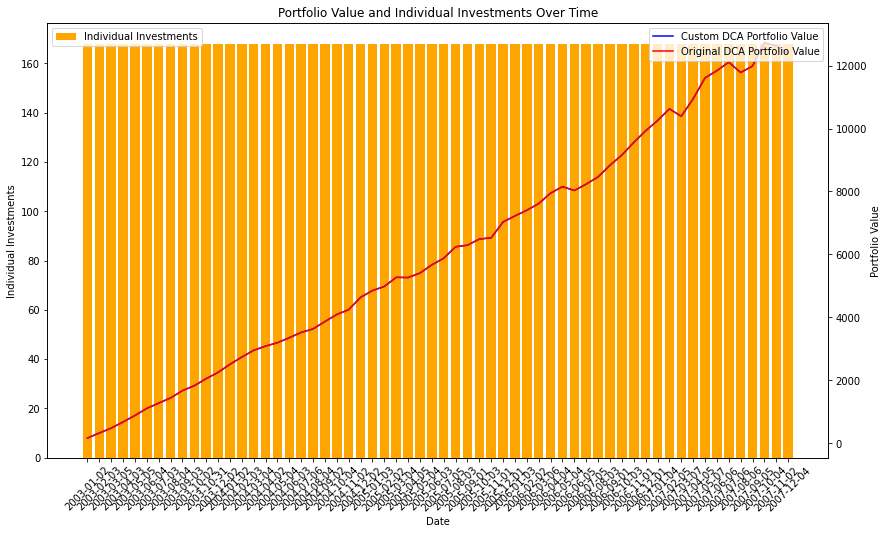

Custom DCA Value:  12397.10075541457
Original DCA Value:  12397.10075541457
Percent (Custom/Original):  100.0


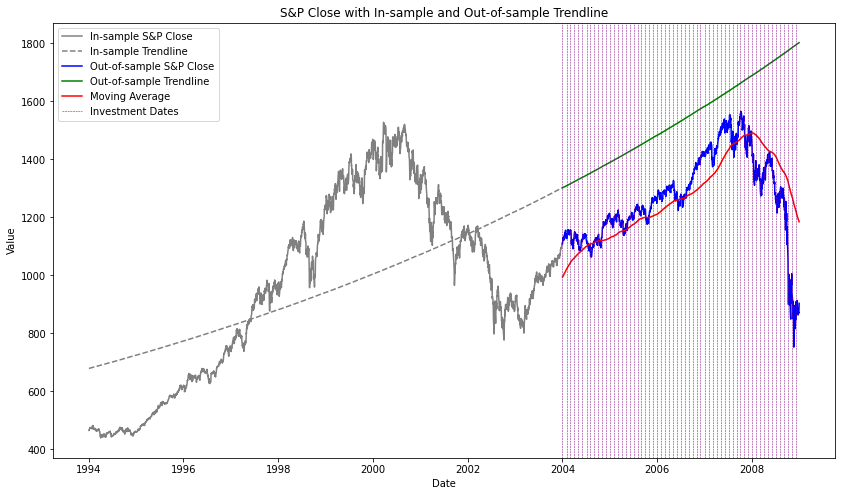

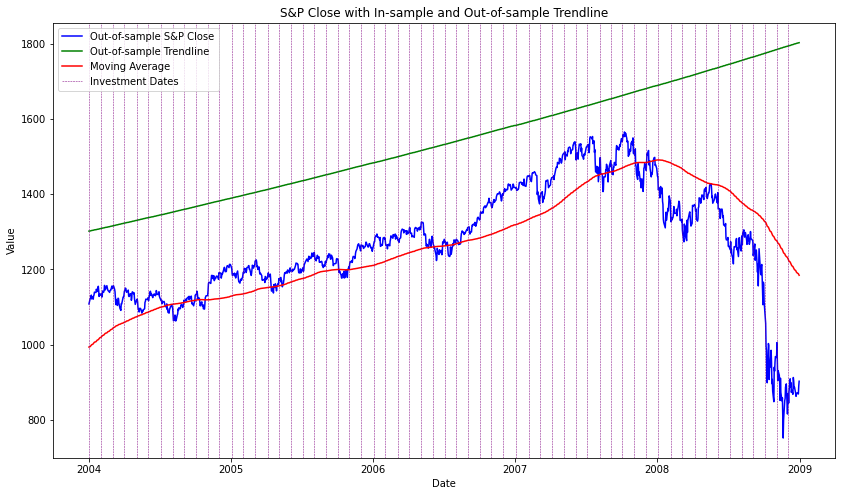

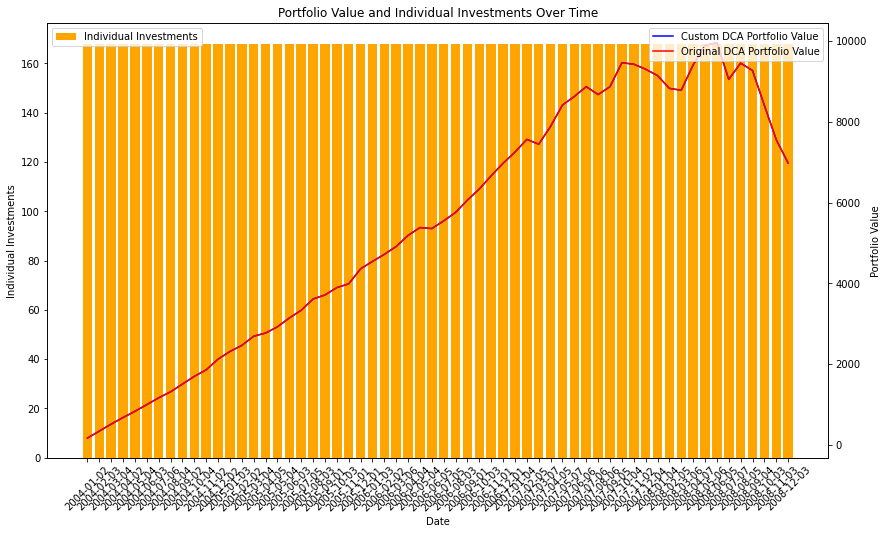

Custom DCA Value:  6980.137777414046
Original DCA Value:  6980.137777414046
Percent (Custom/Original):  100.0


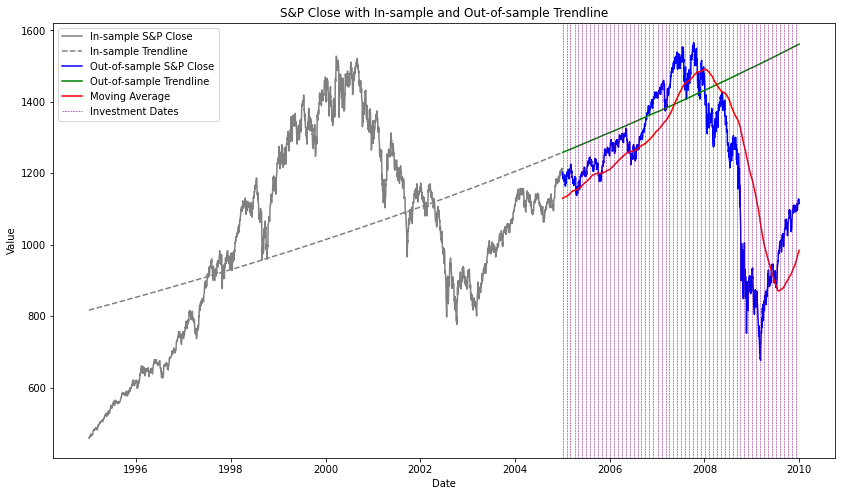

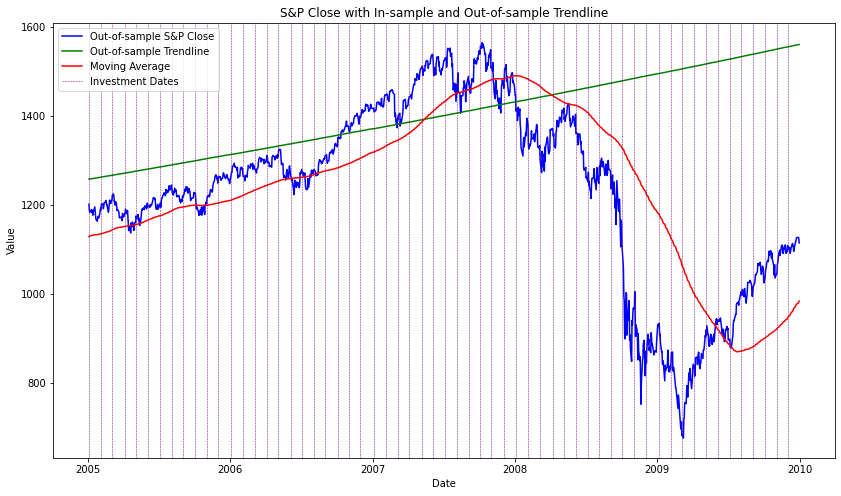

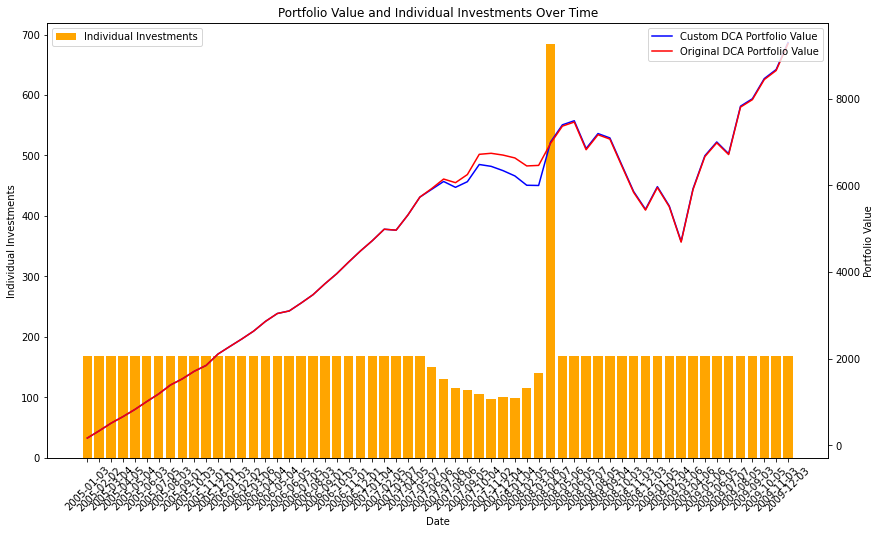

Custom DCA Value:  9289.700825096723
Original DCA Value:  9266.0731889002
Percent (Custom/Original):  100.25499082205422


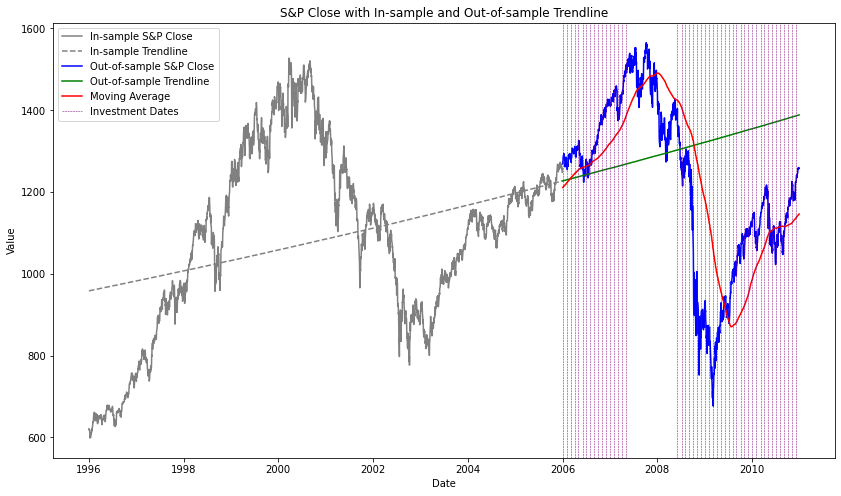

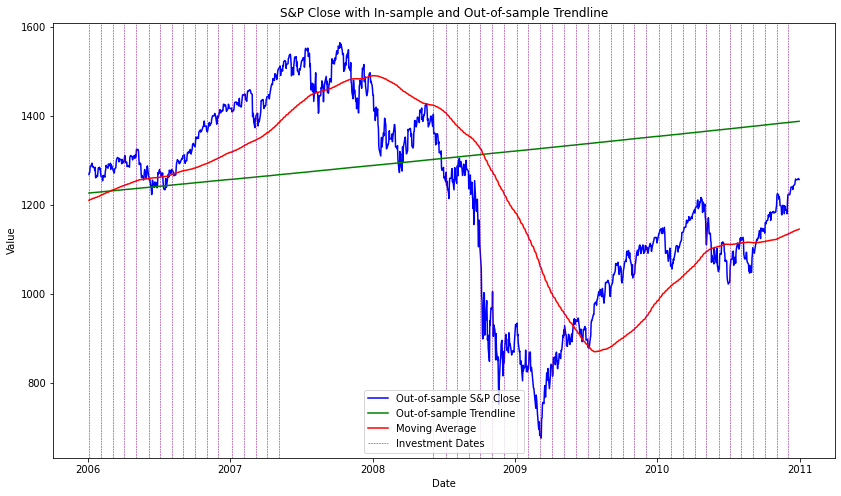

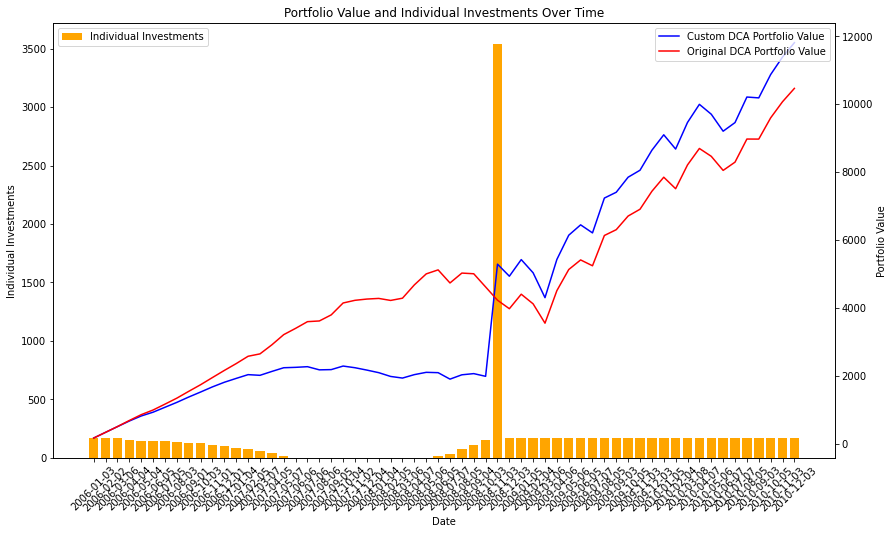

Custom DCA Value:  11811.891039369248
Original DCA Value:  10465.914437398542
Percent (Custom/Original):  112.86057334045307


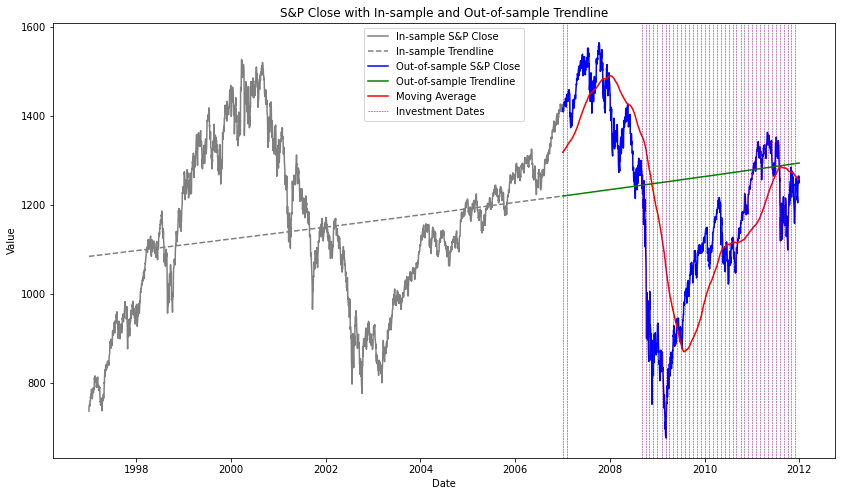

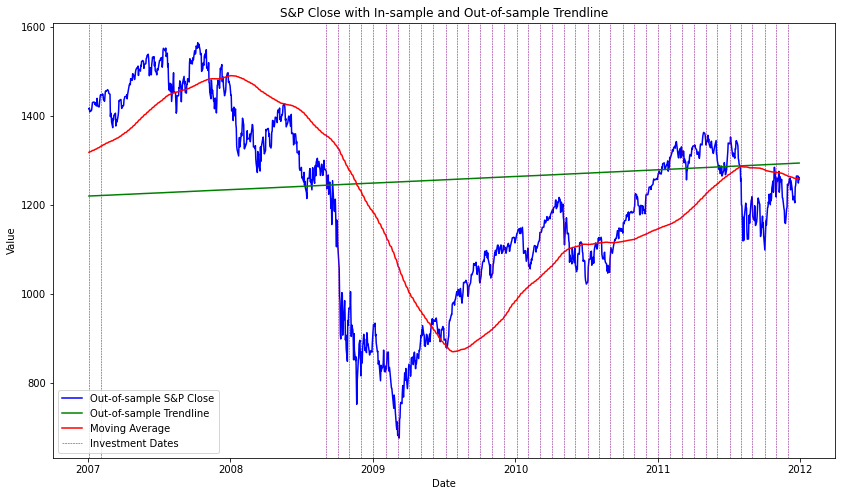

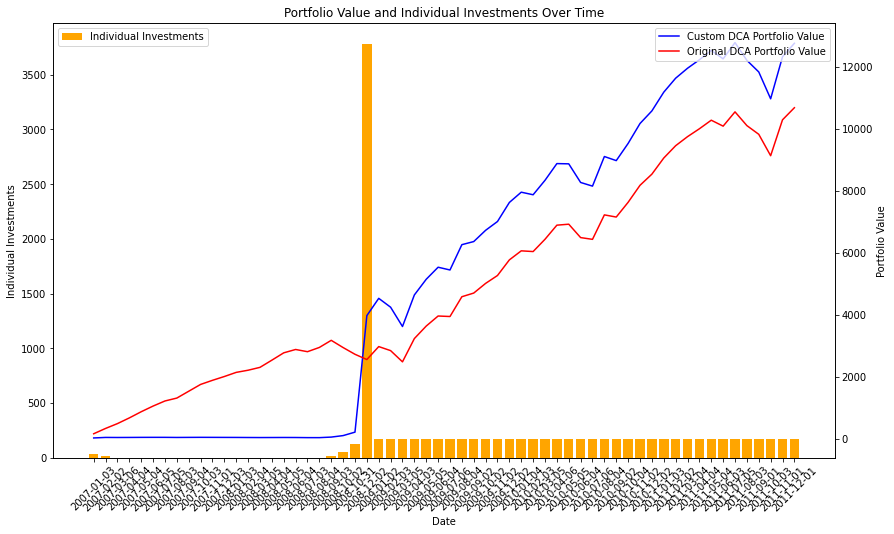

Custom DCA Value:  12760.367820054598
Original DCA Value:  10682.490190665798
Percent (Custom/Original):  119.45124771754453


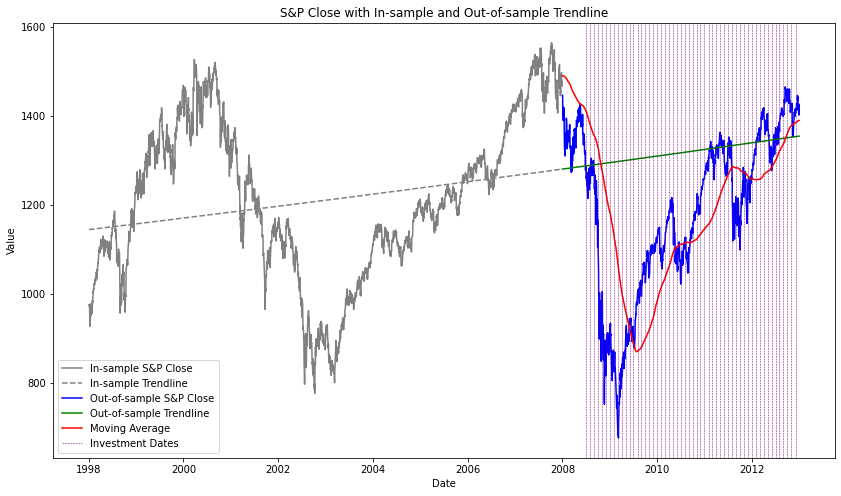

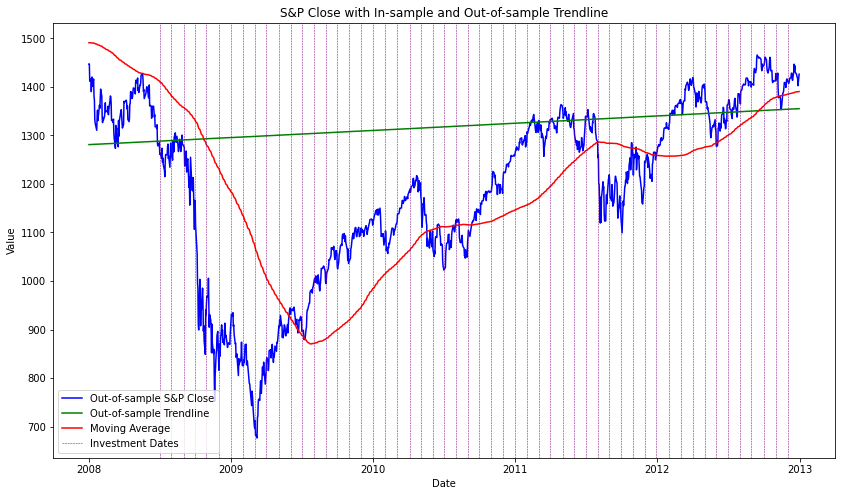

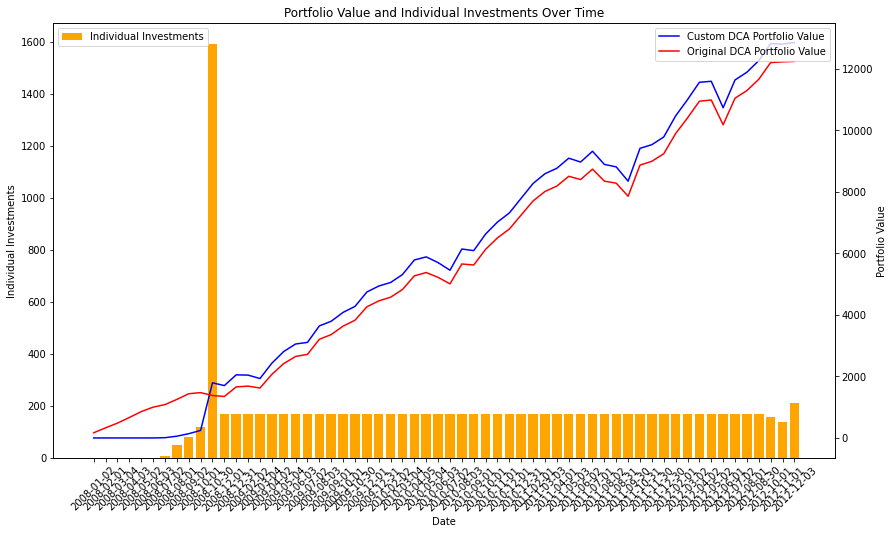

Custom DCA Value:  12848.807437119396
Original DCA Value:  12236.918426824566
Percent (Custom/Original):  105.00035212258592


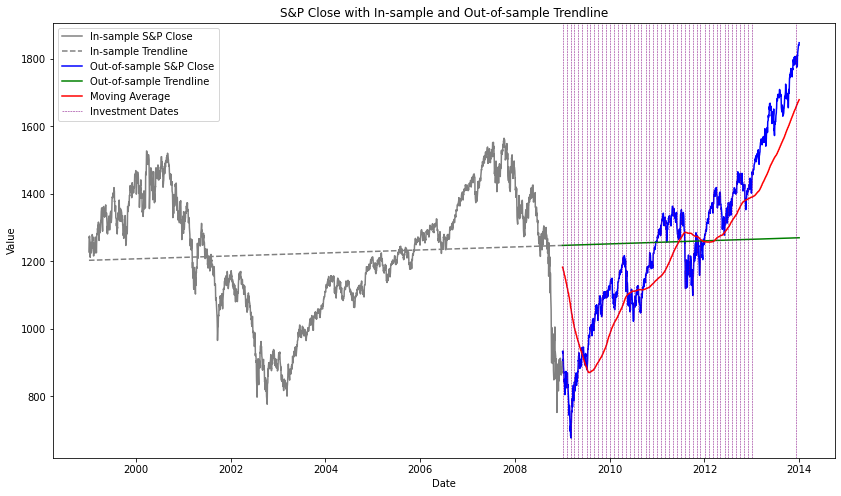

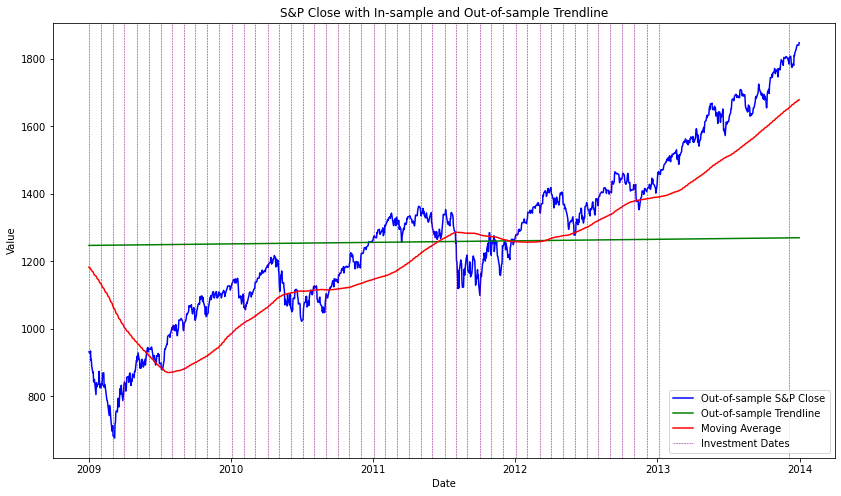

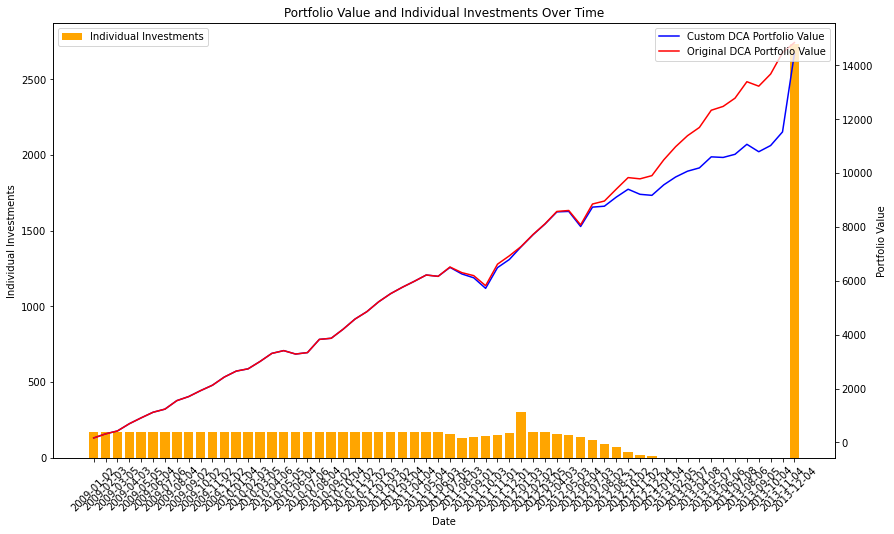

Custom DCA Value:  14423.513935769039
Original DCA Value:  14840.64601051369
Percent (Custom/Original):  97.18925931897346


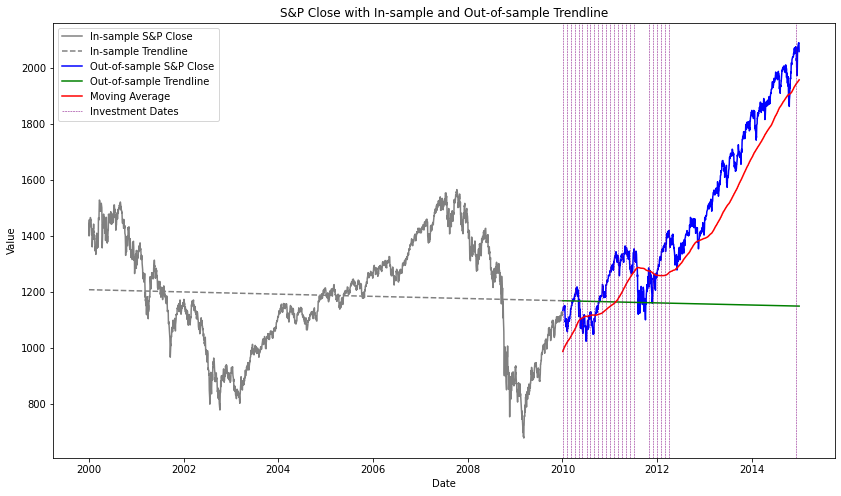

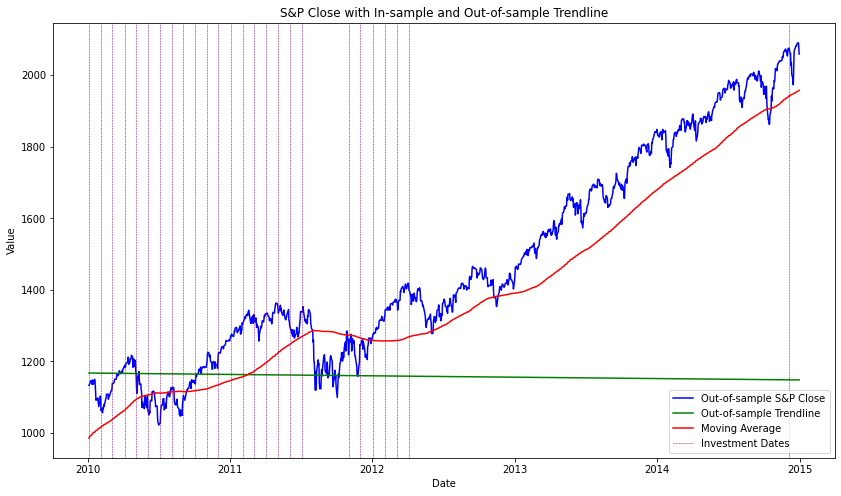

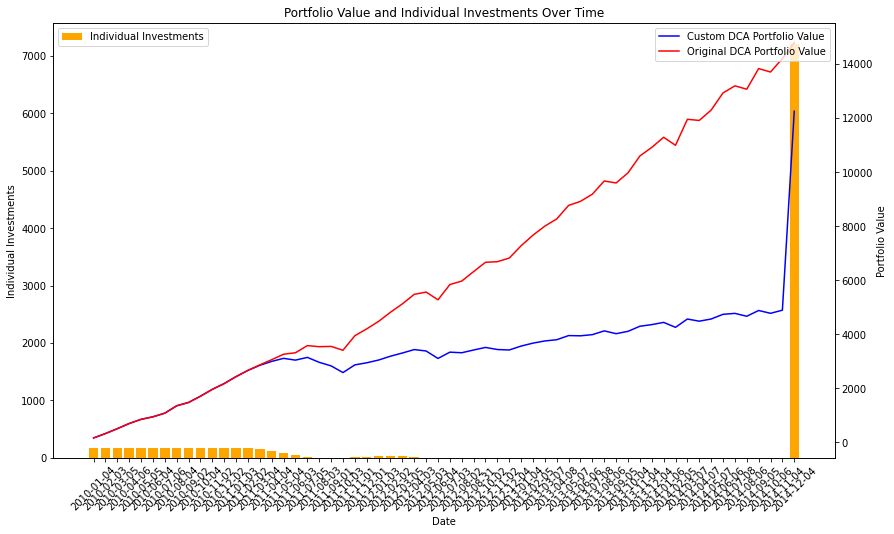

Custom DCA Value:  12255.031919703182
Original DCA Value:  14791.555027833903
Percent (Custom/Original):  82.85154533544555


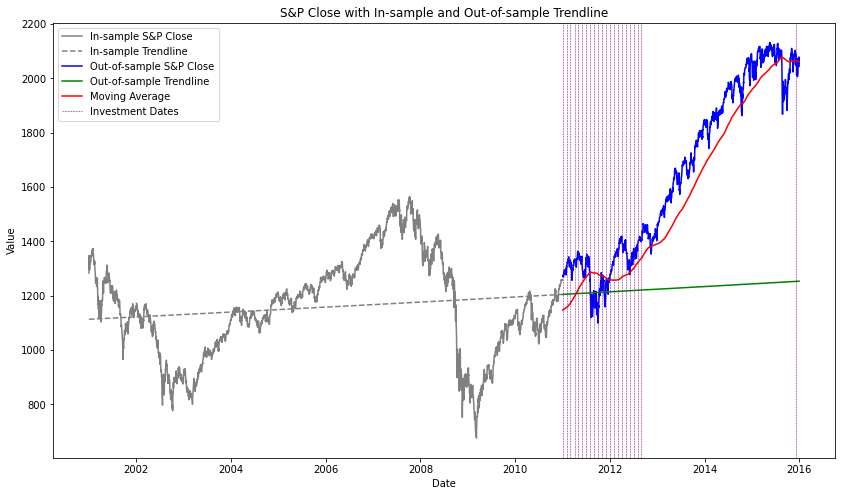

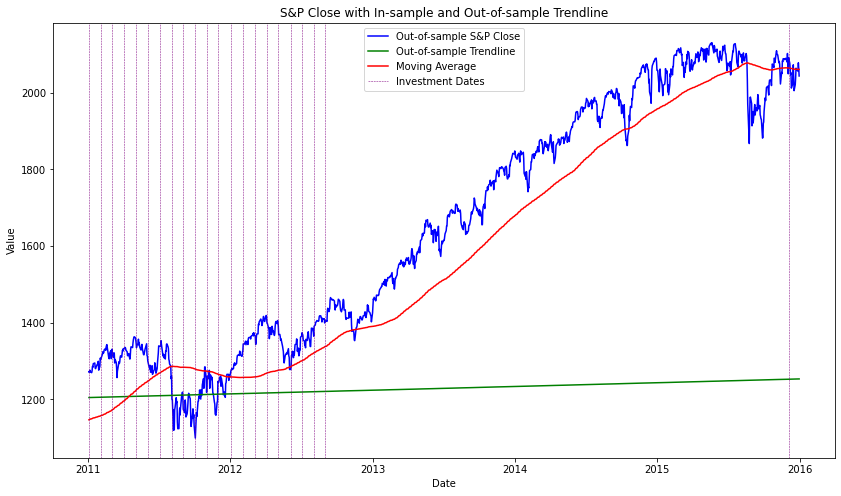

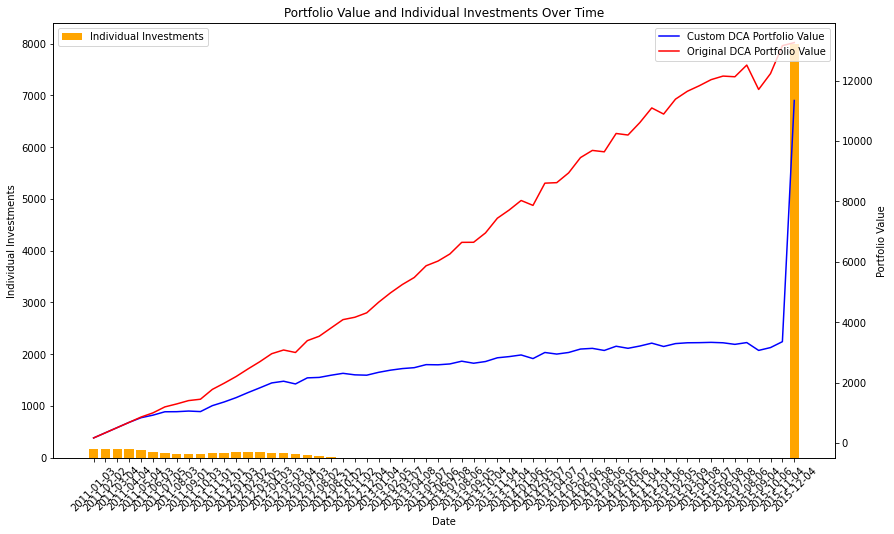

Custom DCA Value:  11340.85808262941
Original DCA Value:  13256.614773280098
Percent (Custom/Original):  85.54867344782419


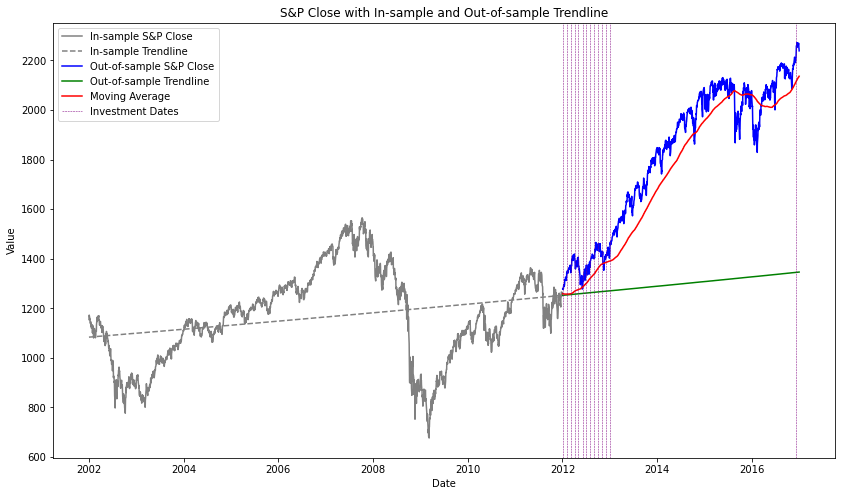

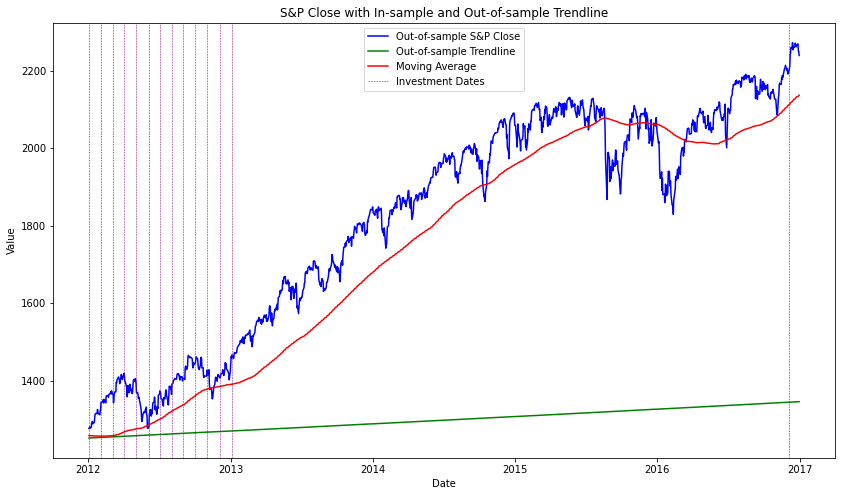

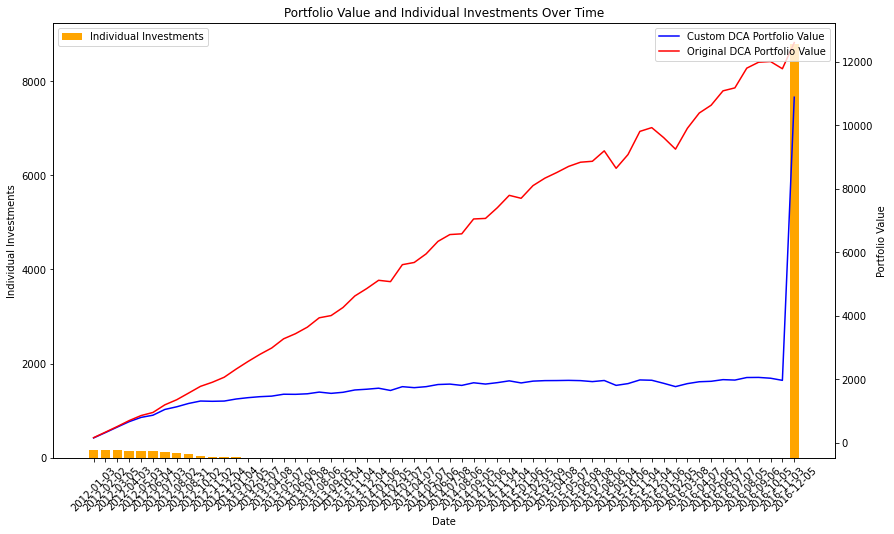

Custom DCA Value:  10883.136827981894
Original DCA Value:  12602.300864978872
Percent (Custom/Original):  86.35833205843828


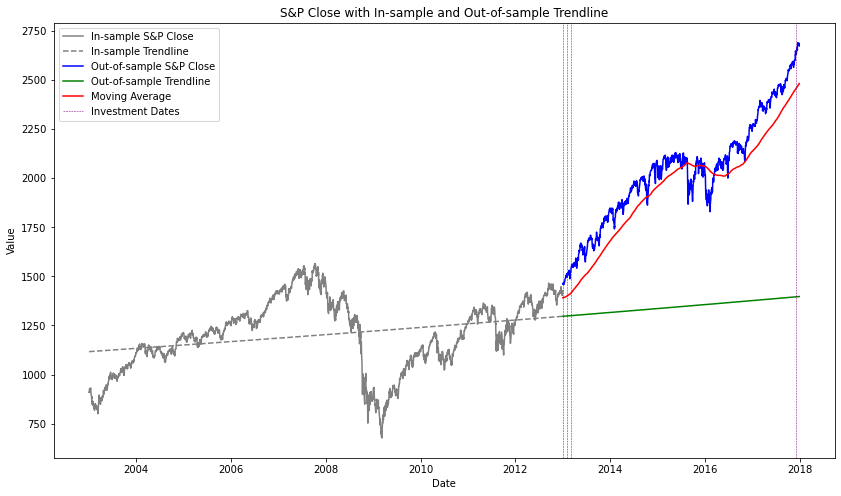

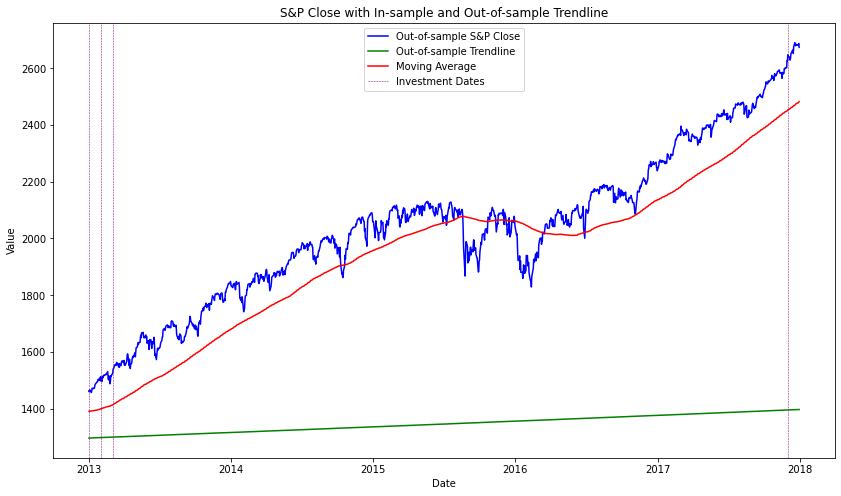

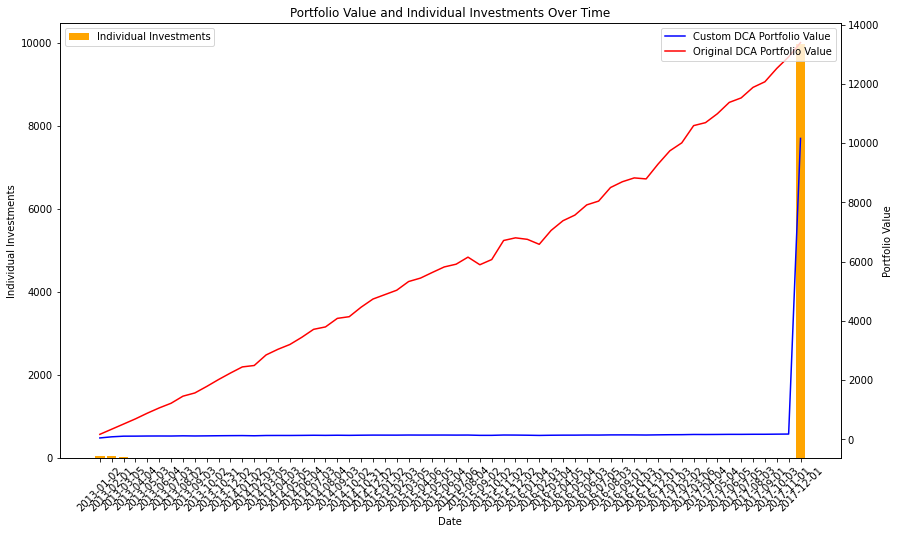

Custom DCA Value:  10158.946092848182
Original DCA Value:  13393.08146389973
Percent (Custom/Original):  75.85219368844301


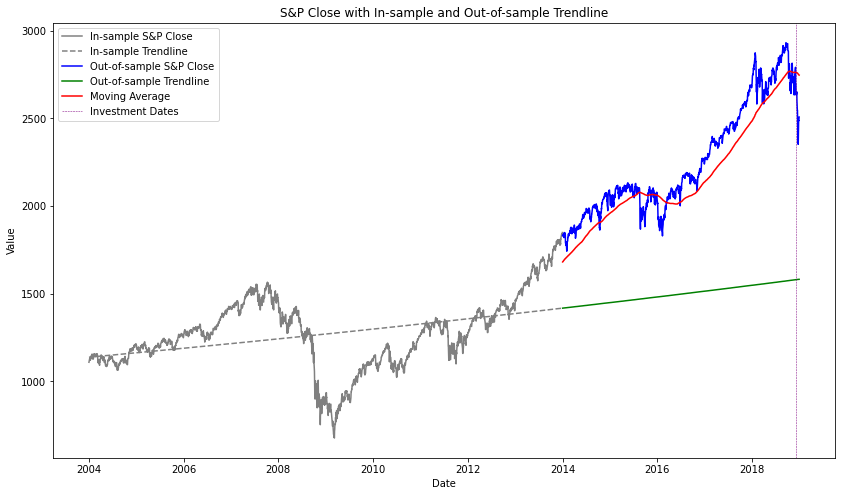

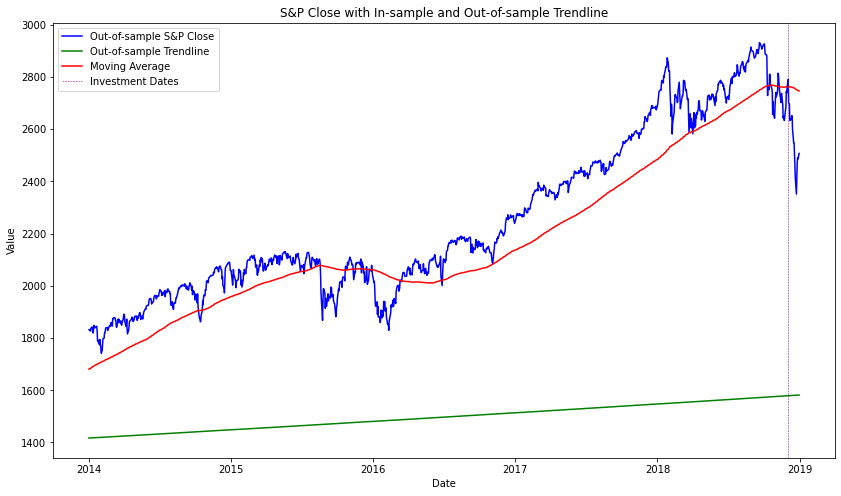

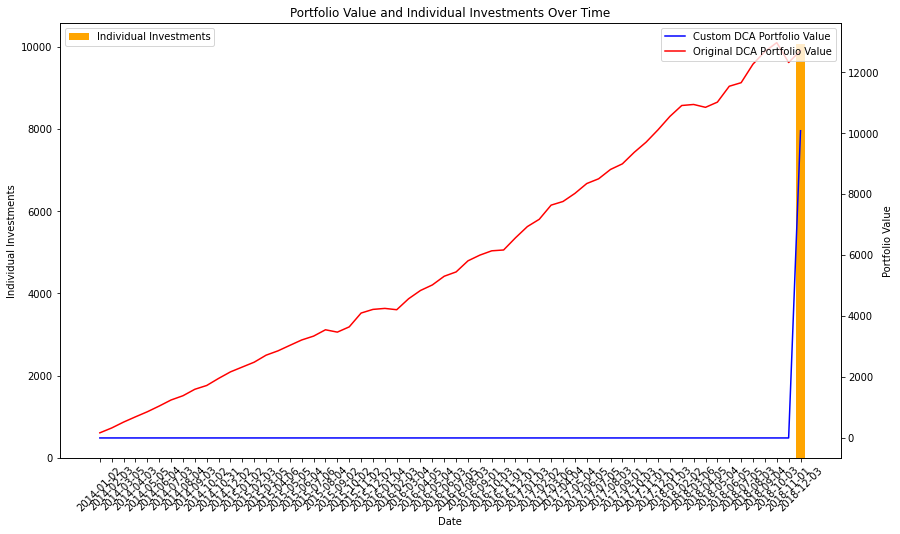

Custom DCA Value:  10080.0
Original DCA Value:  12711.213826495612
Percent (Custom/Original):  79.30005849629376


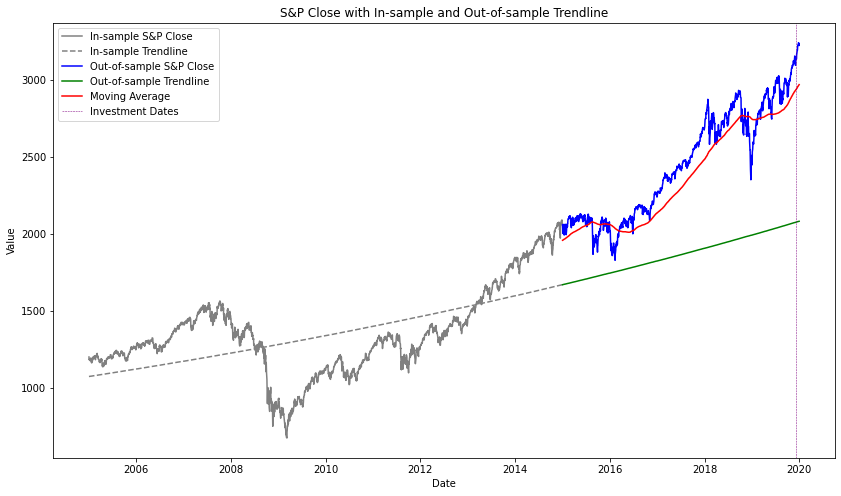

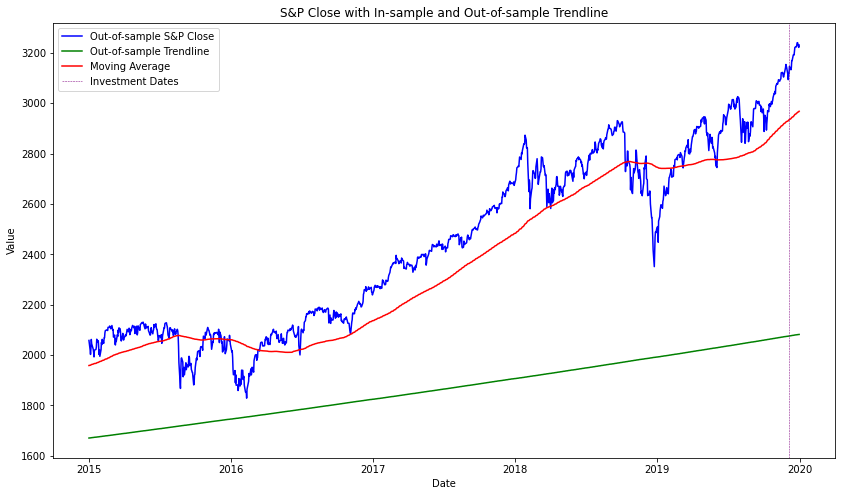

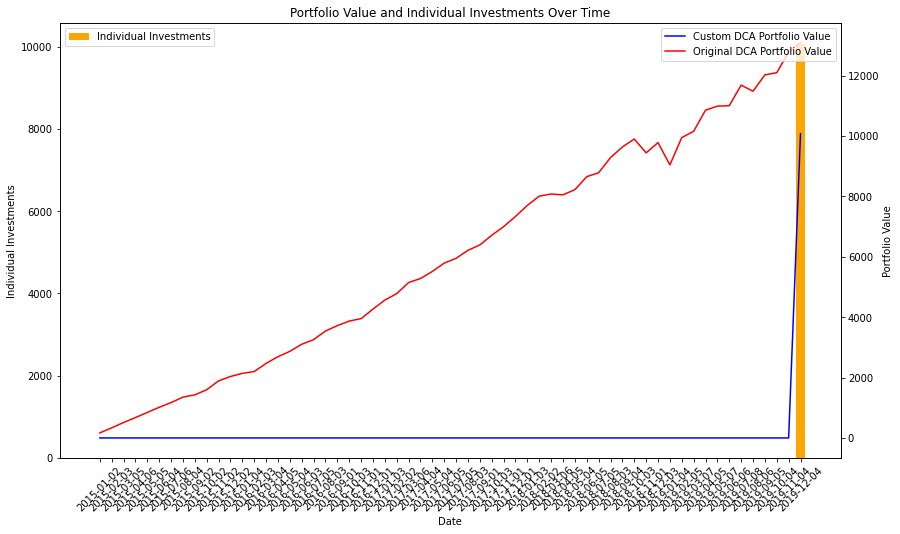

Custom DCA Value:  10080.0
Original DCA Value:  13095.86318971215
Percent (Custom/Original):  76.97087128948206


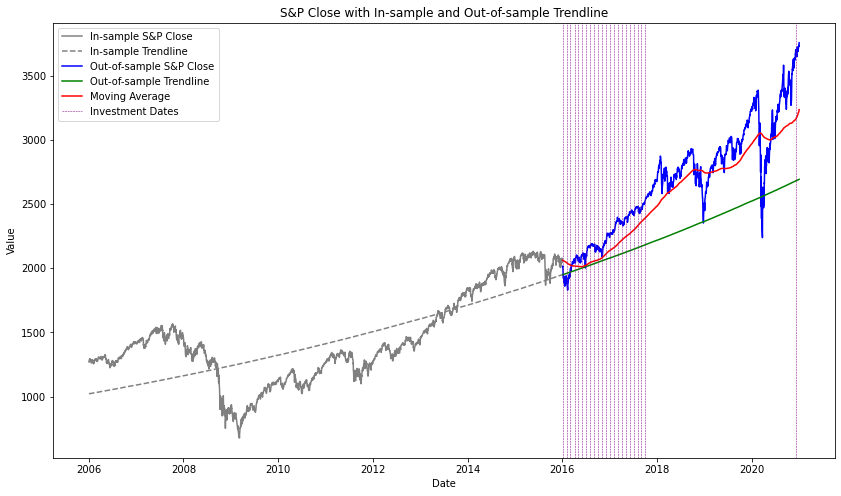

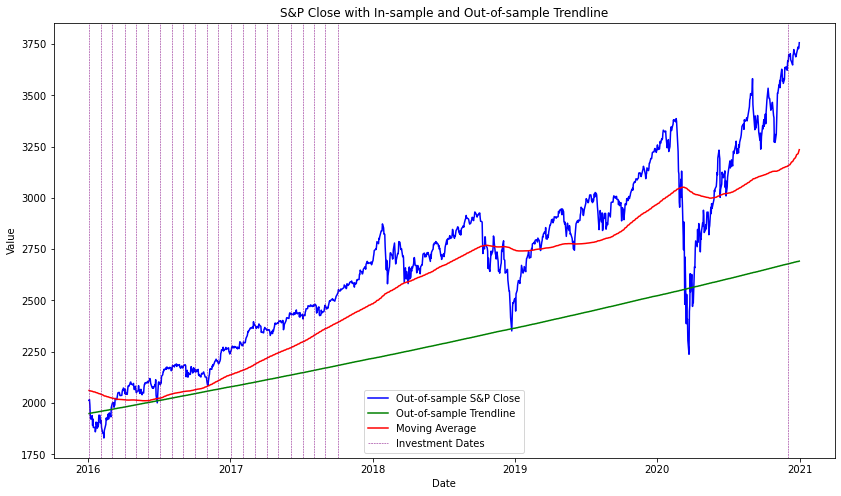

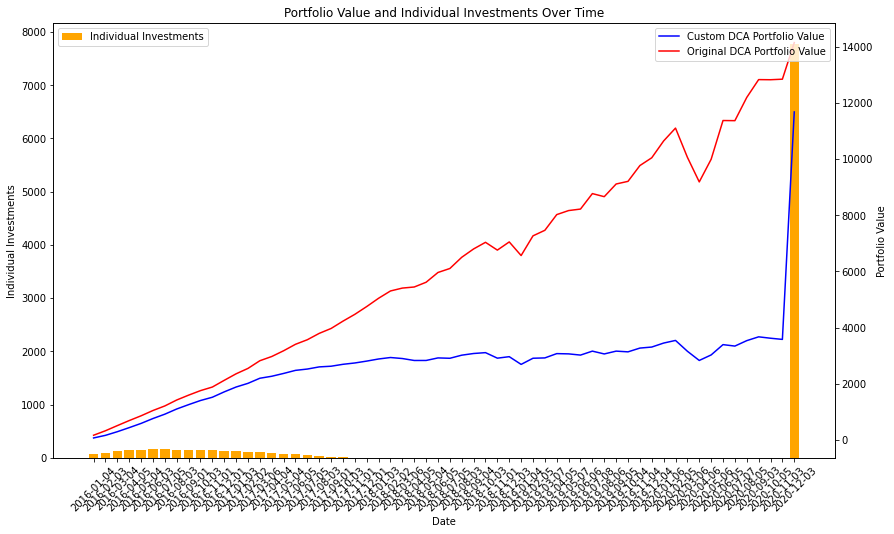

Custom DCA Value:  11679.883577989869
Original DCA Value:  14148.803584187102
Percent (Custom/Original):  82.55032666538298


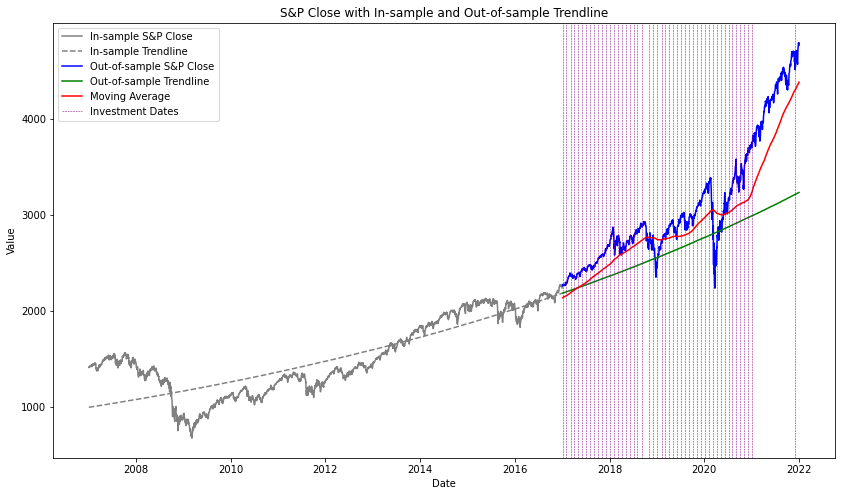

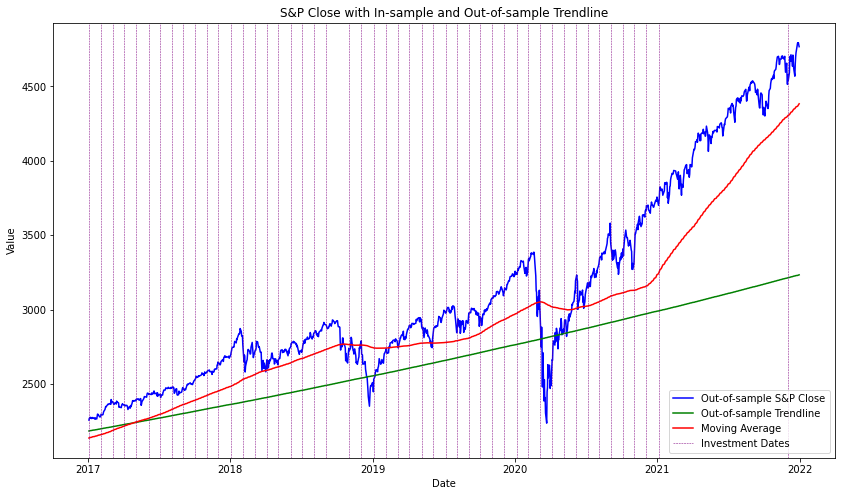

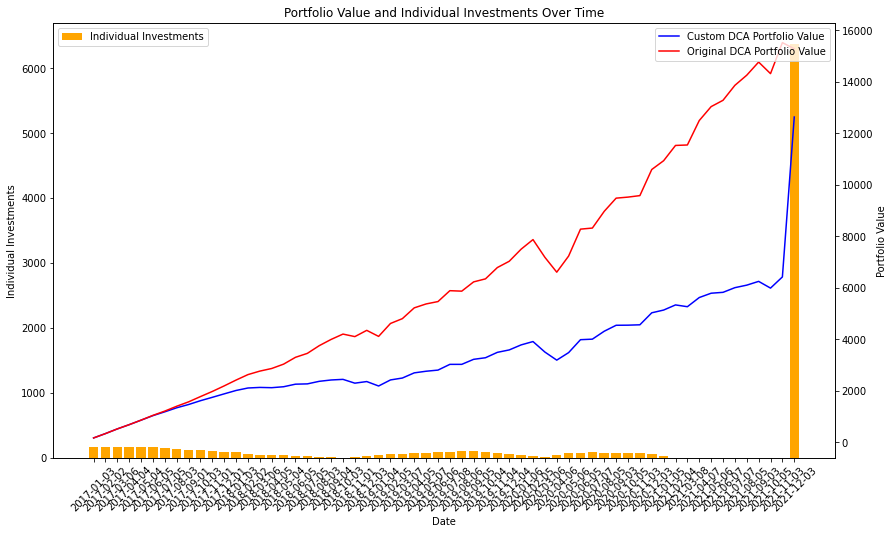

Custom DCA Value:  12635.821858920586
Original DCA Value:  15287.540110848131
Percent (Custom/Original):  82.65438237479509


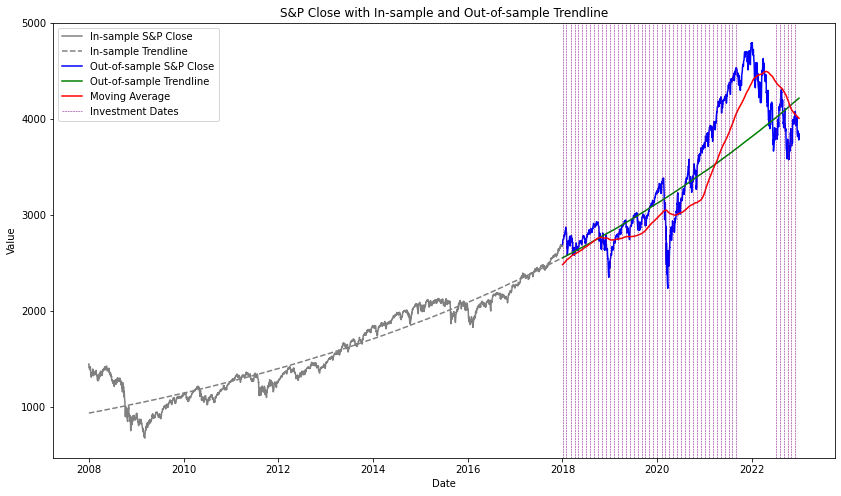

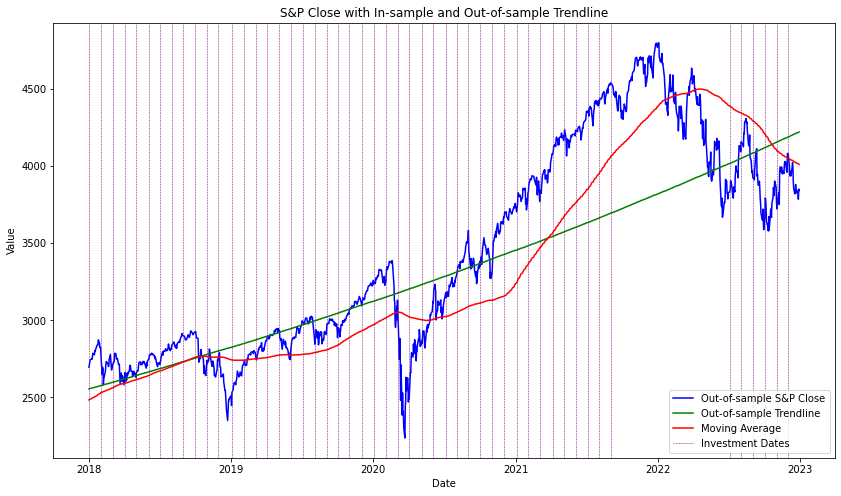

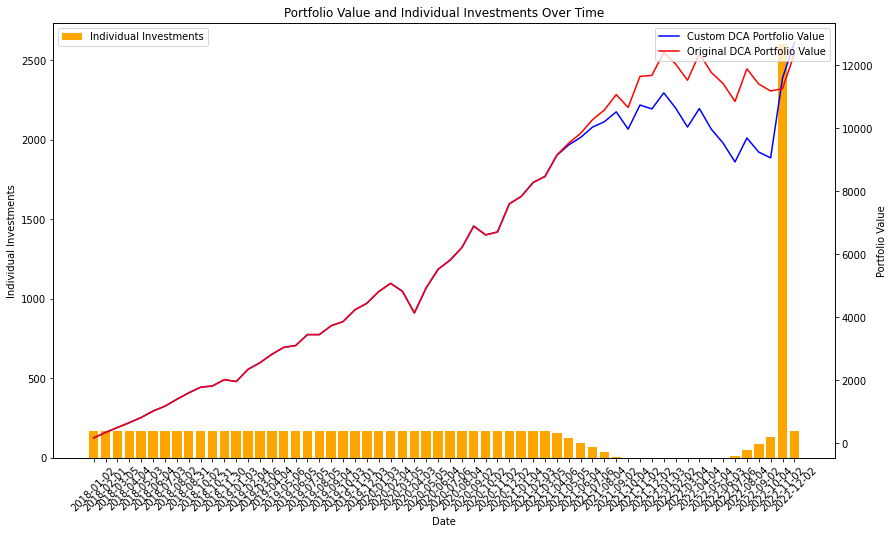

Custom DCA Value:  12724.645586269673
Original DCA Value:  12366.271670159691
Percent (Custom/Original):  102.89799484977151


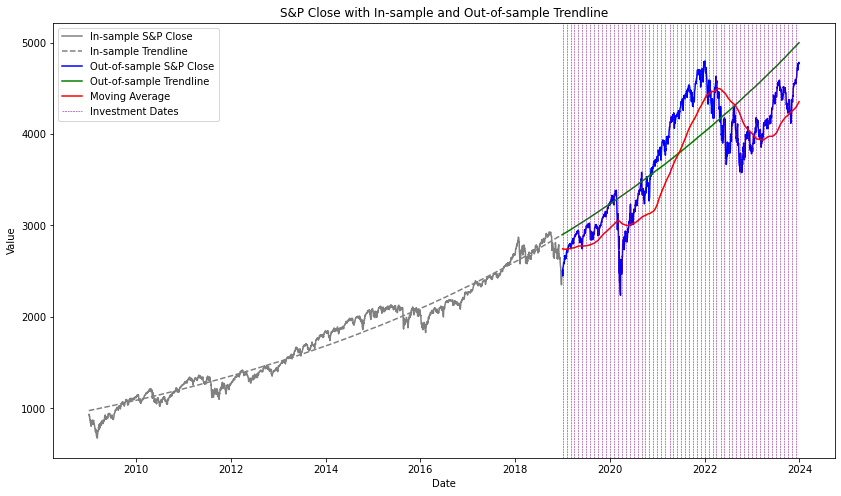

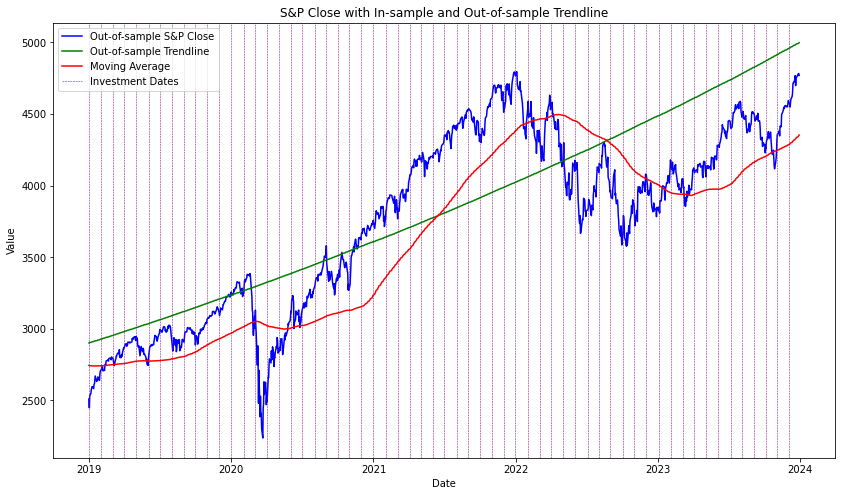

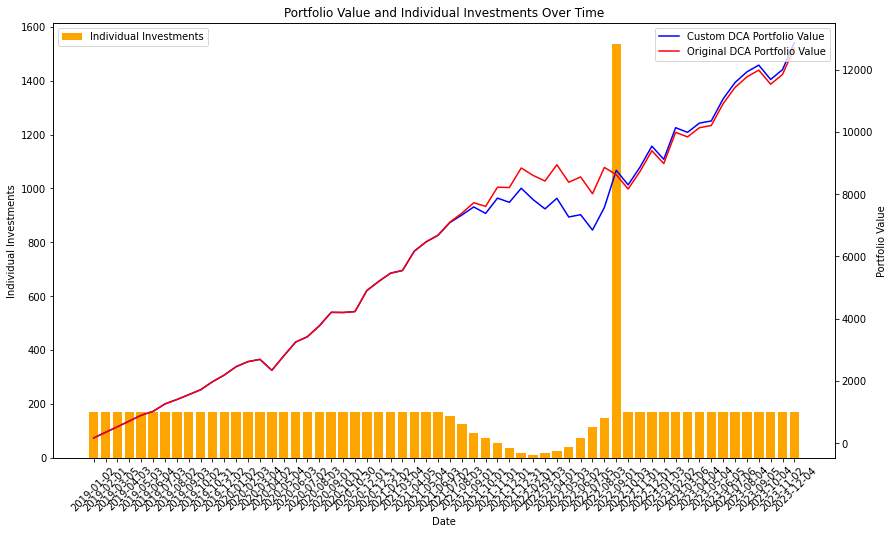

Custom DCA Value:  12868.250590580308
Original DCA Value:  12704.352199696252
Percent (Custom/Original):  101.29009640403368


0.9465703212524551

In [17]:
moving_average = 200
time_interv = 21
date_start = '1980-06-01'
date_end = '2024-06-01'
increment_years = 10  # Length of training period
test_period_years = 5  # Length of testing period
final_results = []
trendline_multiplier= 0.7
max_val = 10

current_year = int(date_start[:4])

while True:
    training_start_date = f"{current_year:04d}-01-01"
    training_end_date = f"{current_year + increment_years - 1:04d}-12-31"
    testing_start_date = f"{current_year + increment_years:04d}-01-01"
    testing_end_date = f"{current_year + increment_years + test_period_years - 1:04d}-12-31"

    if testing_end_date > date_end:
        break

#     result = dca_analysis(
#         sandp_time,
#         trendline_multiplier=trendline_multiplier,
#         moving_average_window=moving_average,
#         time_interval=time_interv,
#         training_start_date = training_start_date,
#         training_end_date=training_end_date,
#         testing_start_date=testing_start_date,
#         testing_end_date=testing_end_date,
#         max_val = max_val,
#         show_graph = True
#     )
    
    result = dca_analysis(sandp_time, 
                     trendline_multiplier=1.0, 
                     moving_average_window=moving_average, 
                     time_interval=time_interv, 
                     training_start_date=training_start_date, 
                     training_end_date=training_end_date, 
                     testing_start_date=testing_start_date, 
                     testing_end_date=testing_end_date, 
                     max_val = max_val, 
                     show_graph = True)
    
    final_results.append((training_start_date, training_end_date, testing_start_date, testing_end_date, result))
    current_year += 1

current = []
old = []

for i in range(len(final_results)):
    current.append(final_results[i][4][0]["portfolio_value"][-1])
    old.append(final_results[i][4][1]["portfolio_value"][-1])
    #print(current[i]/old[i])

percents = np.array(current)/np.array(old)
np.mean(percents)

In [45]:
#import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.optimize import curve_fit

# date_start = '1990-01-01'
# date_end = '2024-12-31'

# def dca_analysis(sandp_time, trendline_multiplier=1.0, moving_average_windows=[20, 50], time_interval=21):
#     sandp_time.index = pd.to_datetime(sandp_time.index)

#     def dca_strategy(df, investment_amount, interval, moving_averages_df, trendline_multiplier):
#         shares_owned = 0
#         portfolio_value = []
#         dates = []
#         investment_history = []
#         aggregated_investment = 0

#         for i in range(0, len(df), interval):
#             current_price = df.iloc[i]['close']
#             ma_value = moving_averages_df['Moving Average'][i]
#             trendline_value = df['Trendline'][i]

#             invested_period = investment_amount + aggregated_investment

#             if ma_value * trendline_multiplier < trendline_value or i >= (len(df) - interval - 2):
#                 shares_bought = invested_period / current_price
#                 shares_owned += shares_bought

#                 current_value = shares_owned * current_price
#                 portfolio_value.append(current_value)
#                 dates.append(df.index[i])
#                 investment_history.append(invested_period)
#                 aggregated_investment = 0
#             else:
#                 current_value = shares_owned * current_price
#                 portfolio_value.append(current_value)
#                 dates.append(df.index[i])
#                 investment_history.append(0)

#                 aggregated_investment += investment_amount

#         return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

#     start_date = date_start
#     end_date = date_end
#     subset_df = sandp_time[start_date:end_date]

#     moving_averages_df = pd.DataFrame()
#     moving_averages_df['Moving Average'] = subset_df['close'].rolling(window=moving_average_windows[0]).mean()

#     x_values = np.arange(len(subset_df))
#     y_values = subset_df['close']

#     def exponential_func(x, a, b):
#         return a * np.exp(b * x)

#     initial_guess = (1.0, 0.001)
#     popt, pcov = curve_fit(exponential_func, x_values, y_values, p0=initial_guess)
#     trendline = exponential_func(x_values, *popt)
#     subset_df['Trendline'] = trendline

#     result_df = dca_strategy(subset_df, 8 * time_interval, time_interval, moving_averages_df, trendline_multiplier)

#     return result_df

# multiplier_values = np.arange(0.1, 2.0, 0.05)
# final_portfolio_values = []

# for multiplier in multiplier_values:
#     final = dca_analysis(sandp_time, trendline_multiplier=multiplier, moving_average_windows=[100, 50], time_interval=21)
#     final_portfolio_values.append(final["portfolio_value"][-1])

# result_tuples = list(zip(multiplier_values, final_portfolio_values))
# result_tuples.sort(key=lambda x: x[1], reverse=True)

# print("Top 5 Trendline Multipliers and Final Portfolio Values:")
# for index, (multiplier, final_value) in enumerate(result_tuples[:5], start=1):
#     print(f"Rank {index}: Trendline Multiplier: {multiplier}, Final Portfolio Value: {final_value}")

# plt.plot(multiplier_values, final_portfolio_values)


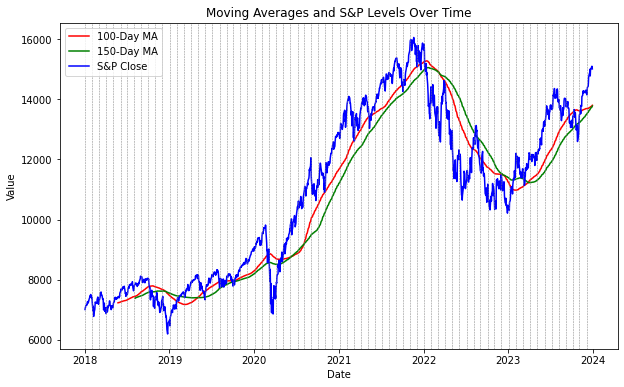

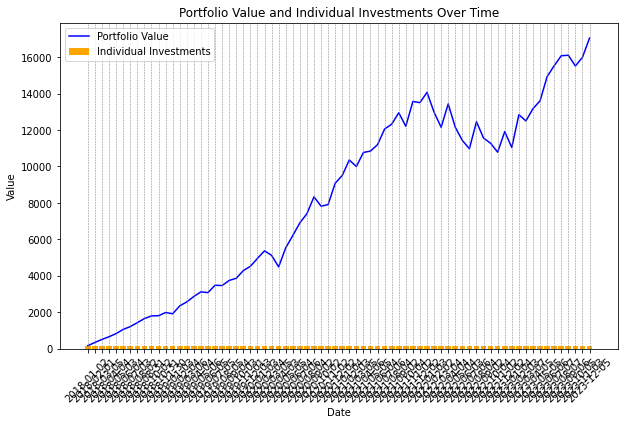

17041.65525532119

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

def dca_analysis(sandp_time, moving_average_windows=[20, 50], time_interval=21):
    # Convert index to datetime if it's not already in datetime format
    sandp_time.index = pd.to_datetime(sandp_time.index)

    # Function to calculate the number of shares bought with a given amount of money
    def calculate_shares(amount, price):
        return amount / price

    # Function to implement DCA strategy with variable granularity and condition
    def dca_strategy(df, investment_amount, interval, moving_averages_df):
        shares_owned = 0  # Initial number of shares owned
        portfolio_value = []  # List to store portfolio value over time
        dates = []  # List to store dates for plotting
        investment_history = []  # List to store amount invested in each interval
        aggregated_investment = 0  # Variable to aggregate investments when condition is met

        for i in range(0, len(df), interval):
            # Check if the 20-day moving average is above the 50-day moving average
            current_price = df.iloc[i]['close']
    
            # Add aggregated investment to current DCA and reset the aggregator
            invested_period = investment_amount + aggregated_investment
            aggregated_investment = 0

            # Buy shares with specified investment amount
            shares_bought = calculate_shares(invested_period, current_price)
            shares_owned += shares_bought

            # Calculate the current value of shares owned
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])  # Capture the date

            # Record the amount invested in this interval
            investment_history.append(invested_period)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

    # Function to calculate moving averages
    def calculate_moving_averages(df, window_sizes):
        moving_averages = {}
        for window in window_sizes:
            ma = df['close'].rolling(window=window).mean()
            moving_averages[f'{window}-Day MA'] = ma
        return pd.DataFrame(moving_averages)

    # Specify the date range interval (start_date and end_date)
    start_date = date_start
    end_date = date_end
    subset_df = sandp_time[start_date:end_date]

    # Calculate moving averages
    moving_averages_df = calculate_moving_averages(subset_df, moving_average_windows)

    # Apply DCA strategy with variable granularity and condition
    result_df = dca_strategy(subset_df, 8 * time_interval, time_interval, moving_averages_df)

    # Plot moving averages and S&P levels
    plt.figure(figsize=(10, 6))
    plt.plot(moving_averages_df.index, moving_averages_df[f'{moving_average_windows[0]}-Day MA'], color='red', label=f'{moving_average_windows[0]}-Day MA')
    plt.plot(moving_averages_df.index, moving_averages_df[f'{moving_average_windows[1]}-Day MA'], color='green', label=f'{moving_average_windows[1]}-Day MA')
    plt.plot(subset_df.index, subset_df['close'], color='blue', label='S&P Close')
    for date in result_df.index[result_df['investment_history'] > 0]:
        plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Moving Averages and S&P Levels Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Plot portfolio value and individual investments over time
    plt.figure(figsize=(10, 6))
    plt.plot(result_df.index.strftime('%Y-%m-%d'), result_df['portfolio_value'], color='blue', label='Portfolio Value')
    plt.bar(result_df.index.strftime('%Y-%m-%d'), result_df['investment_history'], color='orange', label='Individual Investments')
    for date in result_df.index[result_df['investment_history'] > 0]:
        x_value = result_df.index.get_loc(date)
        plt.axvline(x=x_value, color='gray', linestyle='--', linewidth=0.5)

    plt.title('Portfolio Value and Individual Investments Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.show()
    
    return result_df

# Assuming sandp_time is your DataFrame
# Call the function with desired moving average window sizes
final = dca_analysis(sandp_time, moving_average_windows=[100, 150], time_interval=21)
final["portfolio_value"][-1]